# 1. Data Load & Processing

In [1]:
# Check if the tidyverse package is installed, and if not, install it
if (!requireNamespace("tidyverse", quietly = TRUE)) {
  install.packages("tidyverse")
}

# Load the tidyverse package
library(tidyverse)

# Check if the dplyr package is installed, and if not, install it
if (!requireNamespace("dplyr", quietly = TRUE)) {
  install.packages("dplyr")
}

# Load the dplyr package
library(dplyr)

# Check if the readxl package is installed, and if not, install it
if (!requireNamespace("readxl", quietly = TRUE)) {
  install.packages("readxl")
}

# Load the readxl package
library(readxl)

# Check if the reshape2 package is installed, and if not, install it
if (!requireNamespace("reshape2", quietly = TRUE)) {
  install.packages("reshape2")
}

# Load the reshape2 package
library(reshape2)

# Check if the MatchIt package is installed, and if not, install it
if (!requireNamespace("MatchIt", quietly = TRUE)) {
  install.packages("MatchIt")
}

# Load the MatchIt package
library(MatchIt)

# Check if the lmtest package is installed, and if not, install it
if (!requireNamespace("lmtest", quietly = TRUE)) {
  install.packages("lmtest")
}

# Load the lmtest package
library(lmtest)

# Check if the sandwich package is installed, and if not, install it
if (!requireNamespace("sandwich", quietly = TRUE)) {
  install.packages("sandwich")
}

# Load the sandwich package
library(sandwich)

# Check if the gbm package is installed, and if not, install it
if (!requireNamespace("gbm", quietly = TRUE)) {
  install.packages("gbm")
}

# Load the gbm package
library(gbm)

# Check if the vtable package is installed, and if not, install it
if (!requireNamespace("vtable", quietly = TRUE)) {
  install.packages("vtable")
}
library(vtable)

# Check if the zoo package is installed, and if not, install it
if (!requireNamespace("zoo", quietly = TRUE)) {
  install.packages("zoo")
}
library(zoo)




# Set plot options for plot width, height, and resolution
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 200)
# options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 250)

Warning message:
"package 'tidyverse' was built under R version 4.3.2"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'tidyr' was built under R version 4.3.2"
Warning message:
"package 'readr' was built under R version 4.3.2"
Warning message:
"package 'purrr' was built under R version 4.3.2"
Warning message:
"package 'forcats' was built under R version 4.3.2"
Warning message:
"package 'lubridate' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflic

### 1.a. Processing World Bank indicators

In [2]:
# Read indicators from World Bank
wb_indicators_raw <- read_csv("Data\\WDI - WorldBank\\89a9f031-83fe-42e0-a3ba-f7bd3bf9d935_Data.csv")
# Melt dataset to put years to rows
wb_indicators_melted <- melt(wb_indicators_raw, id.vars = c("Country Name", "Country Code", "Series Code", "Series Name"), 
                  variable.name = "Year", value.name = "Value")
# Convert the 'Value' column to numeric, coerce errors
wb_indicators_melted$Value <- as.numeric(as.character(wb_indicators_melted$Value))
# Clean and convert the 'Year' column to numeric
wb_indicators_melted$Year <- gsub("\\[.*\\]", "", wb_indicators_melted$Year)
wb_indicators_melted$Year <- as.numeric(wb_indicators_melted$Year)
# Drop NAs
wb_indicators_long <- na.omit(wb_indicators_melted)
# Convert to wide format, representing each indicator as a column
wb_indicators_wide <- pivot_wider(wb_indicators_long, 
                          id_cols = c("Country Name", "Country Code", "Year"),  # List the columns you want to keep as base dimensions
                          names_from = "Series Code", 
                          values_from = "Value")
# Rename columns
wb_indicators_wide <- wb_indicators_wide %>%
        rename(!!!setNames(c("Country Name", "Country Code", "Year"), c("country", "country_code", "year")))
# Column name mapping
wb_indicators_mapping <- c(
"gdp_per_capita" = "NY.GDP.PCAP.CD",
  "gdp_per_capita_growth_pct" = "NY.GDP.PCAP.KD.ZG",
  "agriculture_pct_gdp" = "NV.AGR.TOTL.ZS",
  "industry_pct_gdp" = "NV.IND.TOTL.ZS",
  "pop_total" = "SP.POP.TOTL",
  "pop_in_largest_city_pct_of_urban_pop" = "EN.URB.LCTY.UR.ZS",
  "pop_growth_pct" = "SP.POP.GROW",
  "pop_density" = "EN.POP.DNST",
  "pop_urban" = "SP.URB.TOTL",
  "pop_urban_pct_of_total" = "SP.URB.TOTL.IN.ZS",
  "pop_rural" = "SP.RUR.TOTL",
  "pop_rural_pct_of_total" = "SP.RUR.TOTL.ZS",
  "gni" = "NY.GDY.TOTL.KN",
  "co2_em_kt" = "EN.ATM.CO2E.KT"
    # ,
  # "co2_em_gaseous_fuel_kt" = "EN.ATM.CO2E.GF.KT",
  # "co2_em_liquid_fuel_kt" = "EN.ATM.CO2E.LF.KT",
  # "co2_em_solid_fuel_kt" = "EN.ATM.CO2E.SF.KT"
)

# Apply remapping of column names
wb_indicators_wide <- wb_indicators_wide %>% rename(!!!wb_indicators_mapping) %>% select(c("country", "country_code", "year", names(wb_indicators_mapping)))
# Sort dataset
wb_indicators_final <- wb_indicators_wide %>% filter(year >= 1995 & year <= 2019) %>% arrange (country, year)
# Check final dataset
print(dim(wb_indicators_final))
head(wb_indicators_final)

Rows: 8783 Columns: 54
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Country Name, Country Code, Series Name, Series Code
dbl (50): 1974 [YR1974], 1975 [YR1975], 1976 [YR1976], 1977 [YR1977], 1978 [...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 6625   17


country,country_code,year,gdp_per_capita,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,pop_total,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_density,pop_urban,pop_urban_pct_of_total,pop_rural,pop_rural_pct_of_total,gni,co2_em_kt
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,AFG,1995,NA,NA,NA,NA,16418912,54.32289,6.046536,25.17350,3550426,21.624,12868486,78.376,NA,1457.69
Afghanistan,AFG,1996,NA,NA,NA,NA,17106595,54.25136,4.103022,26.22786,3714526,21.714,13392069,78.286,NA,1407.30
Afghanistan,AFG,1997,NA,NA,NA,NA,17788819,54.27616,3.910605,27.27384,3878852,21.805,13909967,78.195,NA,1344.10
Afghanistan,AFG,1998,NA,NA,NA,NA,18493132,54.32271,3.882931,28.35370,4049071,21.895,14444061,78.105,NA,1318.00
Afghanistan,AFG,1999,NA,NA,NA,NA,19262847,54.26183,4.077879,29.53383,4235130,21.986,15027717,78.014,NA,1122.00
Afghanistan,AFG,2000,NA,NA,NA,NA,19542982,55.64950,1.443803,29.96333,4314700,22.078,15228282,77.922,NA,1078.12


### 1.b. Processing weather variables

In [3]:
# Read weather datasets
precipitation_raw = read_csv("Data\\Weather\\GDL-Total-Yearly-Precipitation-data.csv", col_types = cols())
humidity_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Relative-Humidity-data.csv", col_types = cols())
avg_surface_temp_raw = read_csv("Data\\Weather\\GDL-Yearly-Average-Surface-Temperature-(ºC)-data.csv", col_types = cols())
# Common fuction to melt and clean weather datasets
clean_weather_datasets <- function (df, measure) {
    # Melt dataset to put years to rows
    df_melted <- melt(df, id.vars = c("Country", "Continent", "ISO_Code", "Level", "GDLCODE", "Region"), 
                    variable.name = "Year", value.name = "Value")
    # Convert the 'Value' column to numeric, coerce errors
    df_melted[measure] <- as.numeric(df_melted$Value)
    # Clean and convert the 'Year' column to numeric
    df_melted$Year <- as.numeric(as.character(df_melted$Year))
    # Drop NAs
    df_final <- na.omit(df_melted)
    # Drop unnecassary columns
    cols_to_drop <- c("Continent", "Level", "GDLCODE", "Region", "Value")
    df_final <- df_final %>% select(-one_of(cols_to_drop))
    # Rename columns
    df_final <- df_final %>%
        rename(!!!setNames(c("Country", "ISO_Code", "Year"), c("country", "country_code", "year")))
    # Return cleaned dataframe
    return (df_final)
    }
# Melt and clean weather datasets
precipitation_final <- clean_weather_datasets(precipitation_raw, "precipitation")
humidity_final <- clean_weather_datasets(humidity_raw, "humidity")
avg_surface_temp_final <- clean_weather_datasets(avg_surface_temp_raw, "avg_surface_temp")
# Check dimensions before join
print(paste0("precipitation_final: " ,dim(precipitation_final)[1], " rows"))
print(paste0("humidity_final: " ,dim(humidity_final)[1], " rows"))
print(paste0("avg_surface_temp_final: " ,dim(avg_surface_temp_final)[1], " rows"))
# Inner join precipitation, humidity and avg surface temperature datasets
weather_joined <- inner_join(precipitation_final, humidity_final, by = c("country", "country_code", "year")) %>%
             inner_join(avg_surface_temp_final, by = c("country", "country_code", "year"))
# Check dimensions after inner join
print(paste0("weather_joined: " ,dim(weather_joined)[1], " rows"))
# Remap country codes to right names and remove duplication on country names
country_remap = c(
  "REU" = "Réunion", # Country was France
  "GUF" = "French Guiana", # Country was France
  "MYT" = "Mayotte", # Country was France
  "TWN" = "Taiwan", # Country was China
  "Z06" = "Unknown1", # Country was Pakistan
  "PRK" = "Unknown2" # Country was Pakistan
)
# Apply the country remap to the country column based on matches with country_code
weather_joined_mapped <- weather_joined %>%
  mutate(country = if_else(country_code %in% names(country_remap), 
                           country_remap[country_code], 
                           country))

outlier_countries <- weather_joined_mapped %>% filter(avg_surface_temp < -1) %>% select (country) %>% unique()
weather_joined_filtered <- weather_joined_mapped %>% filter(!country %in% outlier_countries$country)
# Sort dataset
weather_final <- weather_joined_filtered %>% filter(year >= 1995 & year <= 2019) %>% arrange(country, year)
# Check dataset
print(dim(weather_final))
head(weather_final)

[1] "precipitation_final: 6666 rows"
[1] "humidity_final: 6666 rows"
[1] "avg_surface_temp_final: 6666 rows"
[1] "weather_joined: 6666 rows"
[1] 5000    6


,country,country_code,year,precipitation,humidity,avg_surface_temp
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,AFG,1995,0.016,45.20,8.728
2,Afghanistan,AFG,1996,0.015,45.28,8.676
3,Afghanistan,AFG,1997,0.017,48.20,8.526
4,Afghanistan,AFG,1998,0.017,45.80,9.807
5,Afghanistan,AFG,1999,0.014,45.53,9.722
6,Afghanistan,AFG,2000,0.009,40.39,9.687


### 1.c. Processing EU ETS variables

In [4]:
# Read EU ETS database
eu_ets_raw = read.csv("Data\\EU ETS\\ETS_Database_Jul23.csv", sep = "\t", na.strings = "", fileEncoding = "UTF-8")
# Define the mapping of old names to new names for EUAs
eua_breakdown <- c(
  "1. Total allocated allowances (EUA or EUAA)" = "total_EUAs",
  "1.1 Freely allocated allowances" = "free_EUAs",
  "1.2 Correction to freely allocated allowances (not reflected in EUTL)" = "free_correction_EUAs",
  "1.3 Allowances auctioned or sold (EUAs and EUAAs)" = "auctioned_sold_EUAs"
)
# Drop unnecassary information columns, 
# keep only total EUAs, freely allocated EUAs, correction to freely allocated EUAs and EUAs auctioned or sold
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(ETS.information %in% names(eua_breakdown)) %>%
  mutate(ETS.information = case_when(
    ETS.information %in% names(eua_breakdown) ~ eua_breakdown[ETS.information],
    TRUE ~ ETS.information
  ))
# Define the mapping of old names to new names for sector breakdown
sector_breakdown <- c(
    "20-99 All stationary installations" = "all_stationary",
    "10 Aviation" = "aviation")
# Drop sector breakdown, just include all stationary installations and aviation
# also rename occurences
eu_ets_raw <- eu_ets_raw %>%
  filter(main.activity.sector.name %in% names(sector_breakdown)) %>%
  mutate(main.activity.sector.name = case_when(
    main.activity.sector.name %in% names(sector_breakdown) ~ sector_breakdown[main.activity.sector.name],
    TRUE ~ main.activity.sector.name
  ))
# Remove period aggregates and keep years only
eu_ets_raw <- eu_ets_raw %>% filter(nchar(year) == 4)
# Convert to wide format, representing each EUA breakdown as a column
eu_ets_wide <- pivot_wider(eu_ets_raw, 
                          id_cols = c("country", "country_code", "year"),  # List the columns you want to keep as base dimensions
                          names_from = "ETS.information", 
                          values_from = "value",
                          values_fn = sum)
# Fill NAs with 0
eu_ets_wide[is.na(eu_ets_wide)] <- 0
# Convert year column to numeric
eu_ets_wide$year <- as.numeric(eu_ets_wide$year)
# Apply correction to freely allocated EUAs
eu_ets_wide$free_EUAs <- eu_ets_wide$free_EUAs + eu_ets_wide$free_correction_EUAs
# Drop correction to freely allocated EUAs column
eu_ets_wide$free_correction_EUAs <- NULL
# Rename Northen Ireland to UK
eu_ets_wide$country <- ifelse(eu_ets_wide$country %in% c("United Kingdom (excl. NI)", "Northern Ireland"), "United Kingdom", eu_ets_wide$country)
eu_ets_wide$country_code <- ifelse(eu_ets_wide$country == "United Kingdom", "UK", eu_ets_wide$country_code)
# Aggregate Northen Ireland to UK
eu_ets_final <- eu_ets_wide %>% 
  group_by(country, country_code, year) %>% 
  summarize(
    free_EUAs = sum(free_EUAs),
    total_EUAs = sum(total_EUAs),
    auctioned_sold_EUAs = sum(auctioned_sold_EUAs)
  )
# Sort dataset by country and year
eu_ets_final <- eu_ets_final %>% filter(year <= 2019) %>% arrange(country, year)
# Check dataset
print(dim(eu_ets_final))
head(eu_ets_final)

`summarise()` has grouped output by 'country', 'country_code'. You can override using the `.groups` argument.


[1] 480   6


country,country_code,year,free_EUAs,total_EUAs,auctioned_sold_EUAs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,AT,2005,32412654,32412654,0
Austria,AT,2006,32649366,32649366,0
Austria,AT,2007,32729289,32729289,0
Austria,AT,2008,30718182,30718182,0
Austria,AT,2009,30313132,30718182,405050
Austria,AT,2010,30563812,30963812,400000


### 1.d. Processing PM2.5 variables

In [5]:
# Read PM2.5 data from WHO
pm25_raw = read.csv("Data\\WHO PM2.5\\SDG Indicator 11.6.2. Concentrations of PM2.5.csv")
# Define the mapping of old names to new names for the whole dataset
pm25_columns_old <- c("SpatialDimValueCode", "Location", "Period", "Dim1", "FactValueNumeric")
pm25_columns_new <- c("country_code", "country", "year", "residence_area", "PM25")
# Drop unnecessary columns
pm25_raw <- pm25_raw %>% select(all_of(pm25_columns_old))
# Rename respective columns
pm25_raw <- pm25_raw %>% rename(!!!setNames(pm25_columns_old,pm25_columns_new))
# Convert to long format, also pulling residence area breakdown to columns
pm25_long <- pm25_raw %>%
  pivot_wider(names_from = residence_area,
              values_from = c(PM25),
              names_glue = "{.value}_{residence_area}")
# Sort dataset
pm25_final <- pm25_long %>% arrange (country,year)
# Check dataset
print(dim(pm25_final))
head(pm25_final)
# pm25_long[(pm25_long$country_code == "DEU"),]

[1] 1950    8


country_code,country,year,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,2010,92.79,61.81,68.97,69.67,83.13
AFG,Afghanistan,2011,89.57,60.11,66.94,67.72,80.45
AFG,Afghanistan,2012,92.04,61.09,68.26,68.88,82.40
AFG,Afghanistan,2013,97.49,64.50,72.18,73.01,87.33
AFG,Afghanistan,2014,91.92,60.79,68.06,68.85,82.36
AFG,Afghanistan,2015,90.88,59.99,67.20,67.90,81.38


### 1.e. Combining datasets

In [6]:
# A common function to remap country names to be consistent across data sources
map_countries <- function(df, column_to_map) {
  mapping_dict <- c(
    "Argentina urban" = "Argentina",
    "Bahamas, The" = "Bahamas",
    "Bolivia (Plurinational State of)" = "Bolivia",
    "Cape Verde" = "Cabo Verde",
    "Central African Republic CAR" = "Central African Republic",
    "Chili" = "Chile",
    "Congo Democratic Republic" = "Congo, Dem. Rep.",
    "Democratic Republic of the Congo" = "Congo, Dem. Rep.",
    "Czech Republic" = "Czechia",
    "Egypt, Arab Rep." = "Egypt",
    "Gambia, The" = "Gambia",
    "Guinea Bissau" = "Guinea-Bissau",
    "Iran (Islamic Republic of)" = "Iran",
    "Iran, Islamic Rep." = "Iran",
    "Democratic People's Republic of Korea" = "North Korea",
    "Korea, Dem. People's Rep." = "North Korea",
    "Korea, Rep." = "Korea",
    "Republic of Korea" = "Korea",
    "Kyrgyz Republic" = "Kyrgyzstan",
    "Lao People's Democratic Republic" = "Lao",
    "Lao PDR" = "Lao",
    "Micronesia (Federated States of)" = "Micronesia, Fed. Sts.",
    "Monte Negro" = "Montenegro",
    "Republic of Moldova" = "Moldova",
    "Sao Tome & Principe" = "Sao Tome and Principe",
    "Slovak Republic" = "Slovakia",
    "Syrian Arab Republic" = "Syria",
    "The former Yugoslav Republic of Macedonia" = "North Macedonia",
    "Timor-Leste" = "Timor Leste",
    "Trinidad & Tobago" = "Trinidad and Tobago",
    "Türkiye" = "Turkey",
    "Turkiye" = "Turkey",
    "United States of America" = "United States",
    "Venezuela (Bolivarian Republic of)" = "Venezuela",
    "Venezuela, RB"  = "Venezuela",
    "Viet Nam" = "Vietnam",
    "Yemen, Rep." = "Yemen",
    "United Kingdom of Great Britain and Northern Ireland" = "United Kingdom"
  )
  
  df[[column_to_map]] <- ifelse(df[[column_to_map]] %in% names(mapping_dict), 
                                mapping_dict[df[[column_to_map]]], 
                                df[[column_to_map]])
  
  return(df)
}

# Map country names in each dataset
pm25_final_mapped <- map_countries(pm25_final, "country")
eu_ets_final_mapped <- map_countries(eu_ets_final, "country")
weather_final_mapped <- map_countries(weather_final, "country")
wb_indicators_final_mapped <- map_countries(wb_indicators_final, "country")

# Join each dataset, keeping PM2.5 dataset as the main one to join on
all_indicators <- merge(subset(pm25_final_mapped, select = -country_code), subset(eu_ets_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(weather_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE) %>%
    merge(subset(wb_indicators_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE)

all_indicators_full_join <- merge(subset(pm25_final_mapped, select = -country_code), subset(eu_ets_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE,  all.y = TRUE) %>%
    merge(subset(weather_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE,  all.y = TRUE) %>%
    merge(subset(wb_indicators_final_mapped, select = -country_code), by = c("year", "country"), all.x = TRUE,  all.y = TRUE) %>%
    relocate(co2_em_kt, .after=auctioned_sold_EUAs)

print(dim(all_indicators_full_join))
head(all_indicators_full_join)

[1] 7100   27


,year,country,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban,free_EUAs,total_EUAs,auctioned_sold_EUAs,⋯,industry_pct_gdp,pop_total,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_density,pop_urban,pop_urban_pct_of_total,pop_rural,pop_rural_pct_of_total,gni
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1995,Afghanistan,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,16418912,54.32289,6.0465356,25.17350,3550426,21.62400,12868486,78.37600,NA
2,1995,Africa Eastern and Southern,NA,NA,NA,NA,NA,NA,NA,NA,⋯,27.76402,353466601,27.73389,2.6271070,24.25721,96621116,27.33529,256845485,72.66471,NA
3,1995,Africa Western and Central,NA,NA,NA,NA,NA,NA,NA,NA,⋯,35.90185,235861484,27.96455,2.6932353,26.07420,77992982,33.06728,157868502,66.93272,NA
4,1995,Albania,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,3187784,23.21430,-0.6177037,116.34248,1240399,38.91100,1947385,61.08900,NA
5,1995,Algeria,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,28478022,12.37245,1.9180442,11.95681,15946838,55.99700,12531184,44.00300,5.377309e+12
6,1995,American Samoa,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,53401,NA,2.1062573,267.00500,45540,85.28000,7861,14.72000,NA


# 2. EDA, data cleaning and feature engineering

### 2.a. Gap analysis, summmary statistics

In [7]:
head(all_indicators_full_join)

,year,country,PM25_Cities,PM25_rural,PM25_Total,PM25_Towns,PM25_Urban,free_EUAs,total_EUAs,auctioned_sold_EUAs,⋯,industry_pct_gdp,pop_total,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_density,pop_urban,pop_urban_pct_of_total,pop_rural,pop_rural_pct_of_total,gni
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1995,Afghanistan,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,16418912,54.32289,6.0465356,25.17350,3550426,21.62400,12868486,78.37600,NA
2,1995,Africa Eastern and Southern,NA,NA,NA,NA,NA,NA,NA,NA,⋯,27.76402,353466601,27.73389,2.6271070,24.25721,96621116,27.33529,256845485,72.66471,NA
3,1995,Africa Western and Central,NA,NA,NA,NA,NA,NA,NA,NA,⋯,35.90185,235861484,27.96455,2.6932353,26.07420,77992982,33.06728,157868502,66.93272,NA
4,1995,Albania,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,3187784,23.21430,-0.6177037,116.34248,1240399,38.91100,1947385,61.08900,NA
5,1995,Algeria,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,28478022,12.37245,1.9180442,11.95681,15946838,55.99700,12531184,44.00300,5.377309e+12
6,1995,American Samoa,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,53401,NA,2.1062573,267.00500,45540,85.28000,7861,14.72000,NA


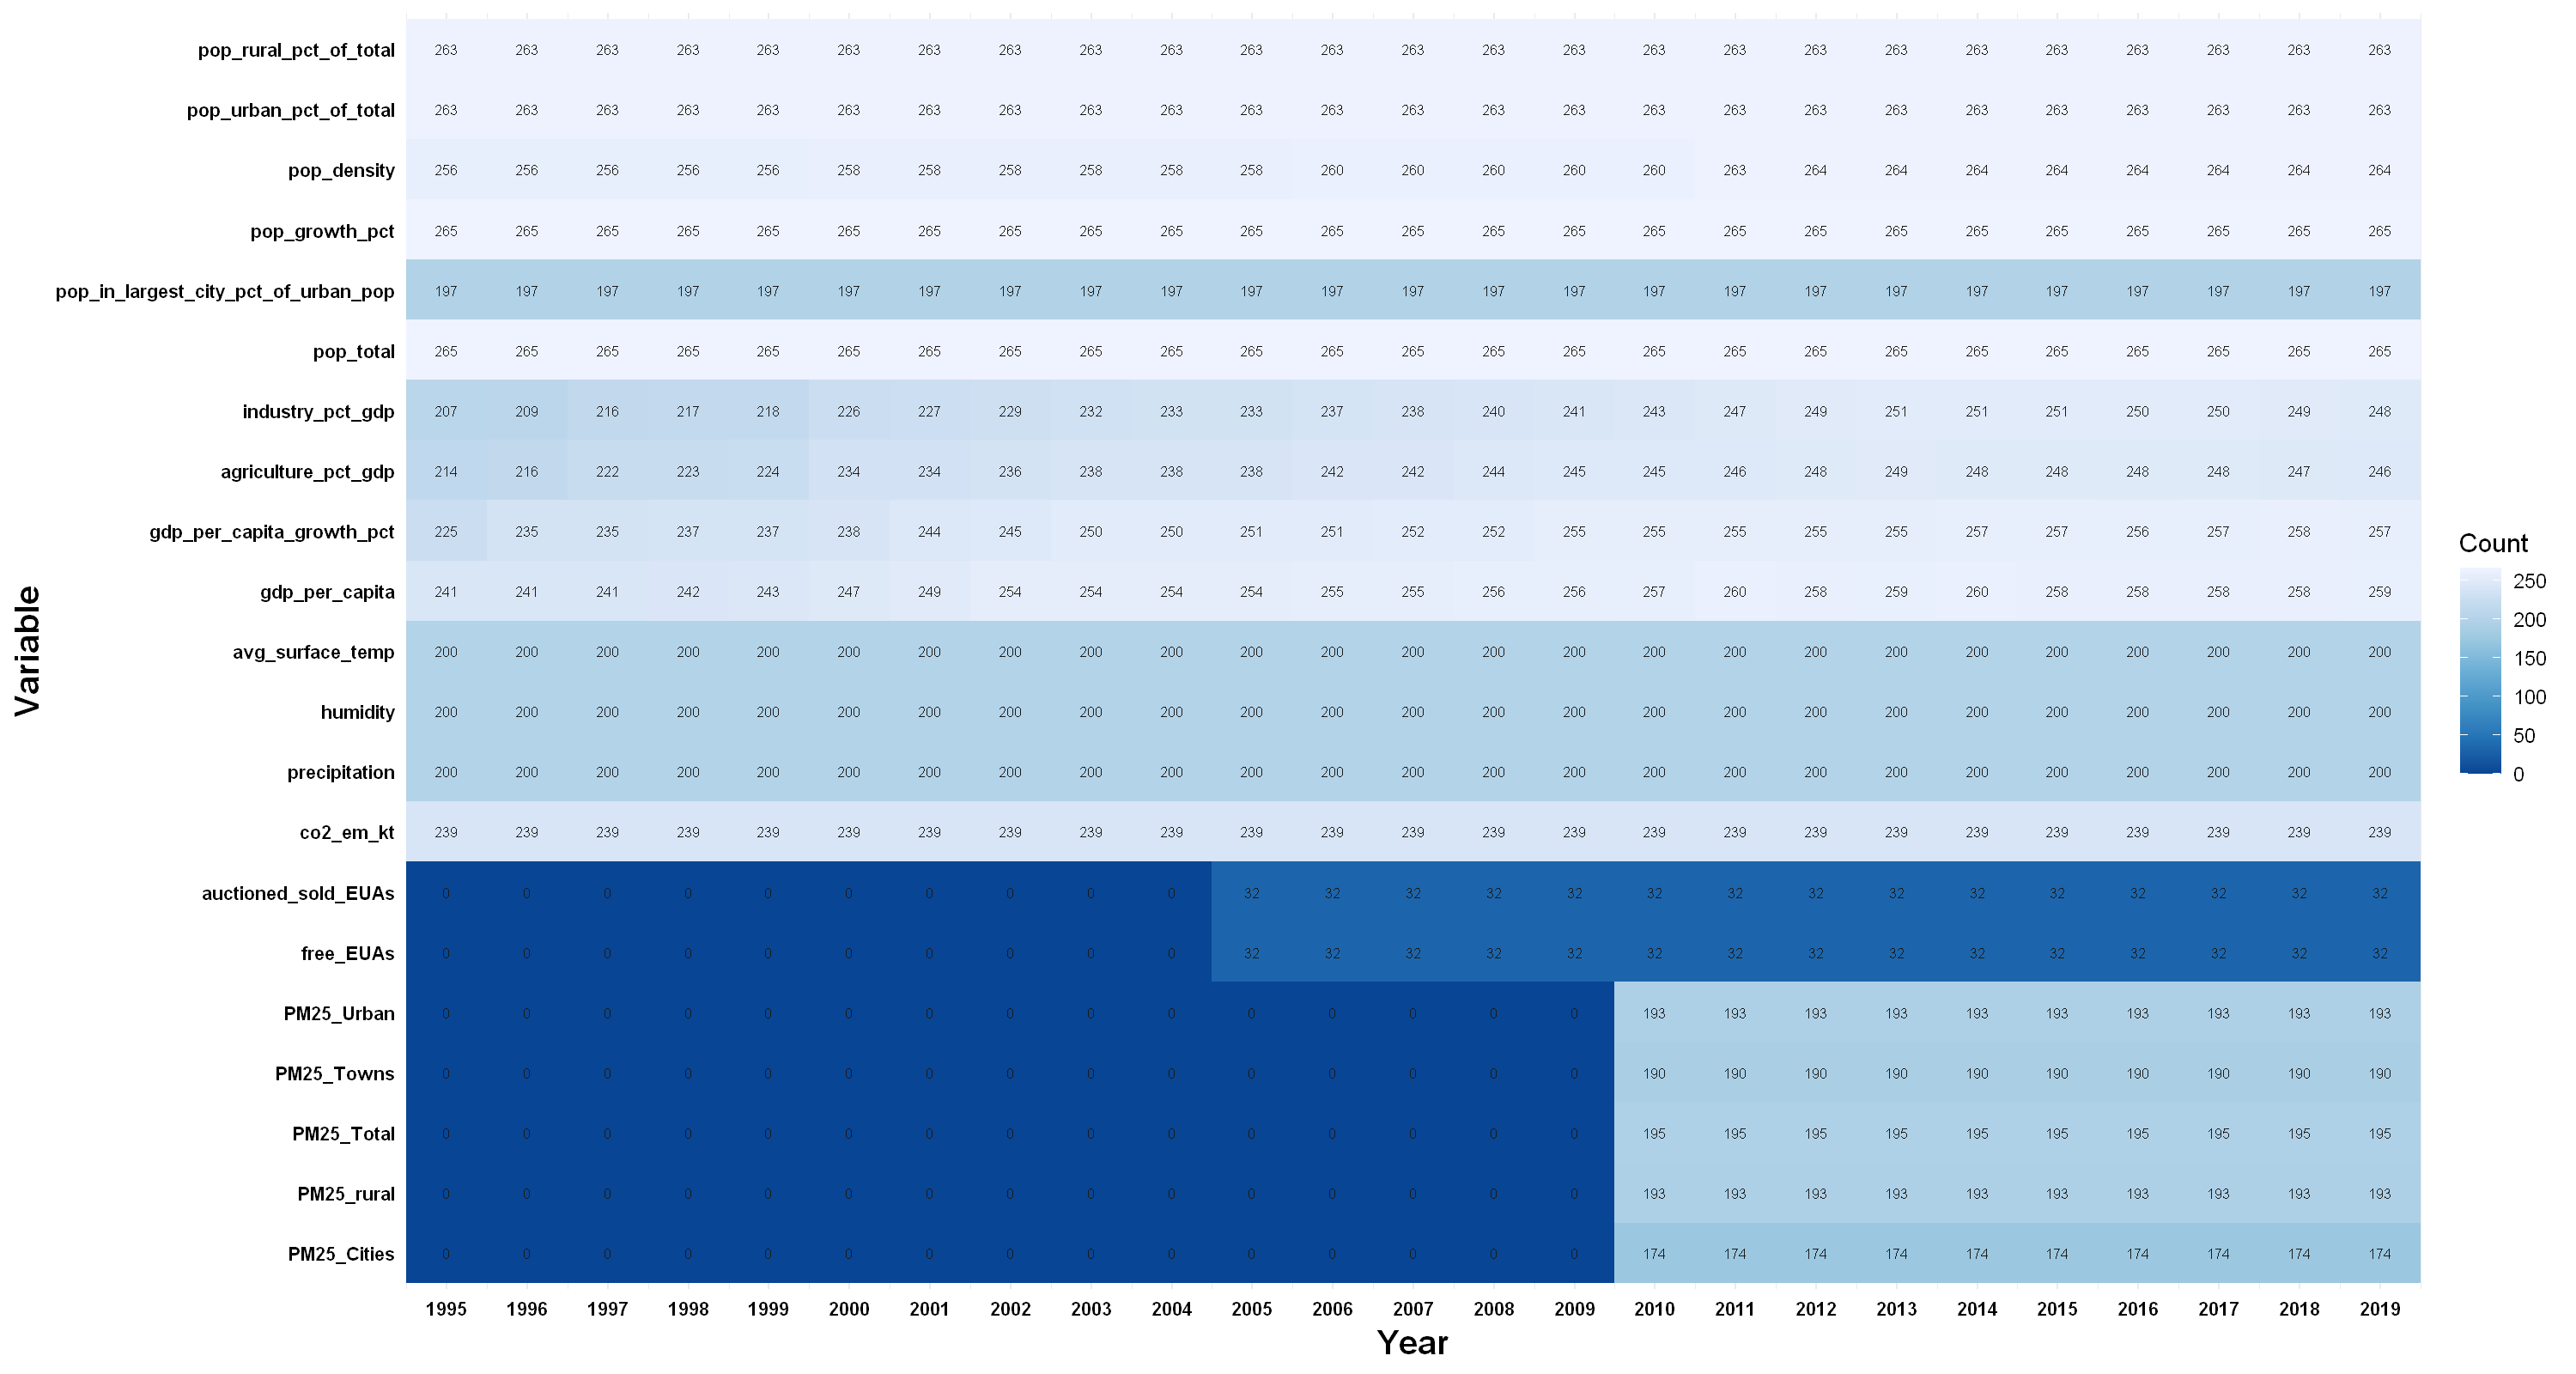

In [8]:
# Drop unnecassary indicators
# For now I decided to drop the rural and urban population counts, since we are already employing the total population count.
# Instead I am employing rural and urban population as a share of total population in percentages.
# Instead of GNI, we are employing GDP per capita
all_indicators <- all_indicators_full_join %>% select(-c(gni,pop_rural,pop_urban,total_EUAs))

# Calculate the number of non-NA values for each column
non_na_counts <- all_indicators %>%
  select(-c(country)) %>%
  group_by(year) %>%
  mutate(across(everything(), ~sum(!is.na(.))))
  
# Reshape the data for plotting while retaining column order
non_na_counts_long <- non_na_counts %>%
  pivot_longer(cols = -year, names_to = "variable", values_to = "count") %>%
  mutate(variable = factor(variable, levels = colnames(non_na_counts)[-1]))  # Exclude the "year" column from levels
non_na_counts_long$variable <- factor(non_na_counts_long$variable, levels = 
  names(all_indicators)[!names(all_indicators) %in% c("year", "country")])

# Create the heatmap
heatmap_plot <- ggplot(data = non_na_counts_long, aes(x = year, y = variable, fill = count)) +
  geom_tile() +
  scale_fill_distiller() +  # Choose color palette
  geom_text(aes(label = ifelse(is.na(count), "", count)), size = 2, color = "gray10") +  # Add text labels with small font
  scale_x_continuous(breaks = seq(min(non_na_counts$year), max(non_na_counts$year), by = 1), expand = c(0, 0)) +  # Display integer values on X-axis
  labs(x = "Year",
       y = "Variable",
       fill = "Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(size = 8, color = "black", face = "bold"),
        axis.text.y = element_text(size = 8, color = "black", face = "bold"),
        axis.title = element_text(size = 14, color = "black", face = "bold")) 

# Display the heatmap
print(heatmap_plot)

# Save the plot with adjusted width
ggsave("images/EDA_heatmap_plot.jpg", heatmap_plot, width = 12, height = 5, create.dir = TRUE)

[DONE] Apply imputation for missing records for EU ETS countries only 2010 - 2019

[DONE] Apply imputation for missing records for non - EU ETS countries only 2010 - 2019

[DONE] Apply imputation for missing records for EU ETS countries only 1995 - 2005

[DONE] Apply imputation for missing records for non - EU ETS countries only 1995 - 2005

In [9]:
# Check summary statistics
stobj_raw <- st(all_indicators, out = "return")
stobj_raw

Variable,N,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
year,7100,2007,7.2,1995,2001,2013,2019
PM25_Cities,1740,27,17,4.6,15,36,97
PM25_rural,1930,21,13,4.9,10,28,68
PM25_Total,1950,23,14,4.9,11,30,72
PM25_Towns,1900,23,14,5.2,12,30,73
PM25_Urban,1930,24,16,4.9,12,32,87
free_EUAs,480,46911789,74881285,0,4499131,58487808,497302479
auctioned_sold_EUAs,480,12563631,28799432,0,0,11136875,210550000
co2_em_kt,5975,1067727,3463285,0,2452,269127,35560556


### 2.b. Data cleaning

In [10]:
# 0 precipitation seems like a data quality issue, therefore dropping respective row.
# Only for 2010, Bahrain. Not mentioned in thesis document since this is not an EU ETS country.
all_indicators_filtered <- all_indicators %>% filter (precipitation > 0)

# Drop EU ETS country Liechtenstein as the target variable is missing and no need to bother with data imputation
all_indicators_filtered <- all_indicators_filtered %>% filter(country != "Liechtenstein")

In [11]:
# pop_growth_pct spans between -17% to 19%
# Trimming only 0.1% from each ends of the distribution to remove outliers
lower_quantile <- quantile(all_indicators_filtered$pop_growth_pct, probs = 0.003, na.rm = TRUE)
print(paste0("Lower quantile is: ", round(lower_quantile,2), "%"))
upper_quantile <- quantile(all_indicators_filtered$pop_growth_pct, probs = 0.997, na.rm = TRUE)
print(paste0("Upper quantile is: ", round(upper_quantile,2), "%"))
# Check countries and years to be dropped
all_indicators_filtered %>% 
    filter(pop_growth_pct < lower_quantile | pop_growth_pct > upper_quantile) %>%
    select(c("country", "year", "pop_growth_pct"))
# Replace respective records with NAs
all_indicators_filtered$pop_growth_pct[all_indicators_filtered$pop_growth_pct < lower_quantile | 
                                          all_indicators_filtered$pop_growth_pct > upper_quantile] <- NA

[1] "Lower quantile is: -3.21%"
[1] "Upper quantile is: 9.82%"


country,year,pop_growth_pct
<chr>,<dbl>,<dbl>
Georgia,1995,-3.757716
Rwanda,1995,-16.880630
Georgia,1996,-3.629546
Rwanda,1996,16.625502
Rwanda,1997,13.247067
Kosovo,1998,-5.924733
Liberia,1998,10.199885
Kosovo,1999,-10.955149
Kosovo,2000,-3.582128


In [12]:
# gdp_per_capita_growth_pct spans between -48% to 96%
# Trimming only 0.3% from each ends of the distribution to remove outliers
lower_quantile <- quantile(all_indicators_filtered$gdp_per_capita_growth_pct, probs = 0.003, na.rm = TRUE)
print(paste0("Lower quantile is: ", round(lower_quantile,2), "%"))
upper_quantile <- quantile(all_indicators_filtered$gdp_per_capita_growth_pct, probs = 0.997, na.rm = TRUE)
print(paste0("Upper quantile is: ", round(upper_quantile,2), "%"))
# Check countries and years to be dropped
all_indicators_filtered %>% 
    filter(gdp_per_capita_growth_pct < lower_quantile | gdp_per_capita_growth_pct > upper_quantile) %>%
    select(c("country", "year", "gdp_per_capita_growth_pct"))
# Replace respective records with NAs
all_indicators_filtered$gdp_per_capita_growth_pct[all_indicators_filtered$gdp_per_capita_growth_pct < lower_quantile | 
                                          all_indicators_filtered$gdp_per_capita_growth_pct > upper_quantile] <- NA

[1] "Lower quantile is: -18.17%"
[1] "Upper quantile is: 25.99%"


country,year,gdp_per_capita_growth_pct
<chr>,<dbl>,<dbl>
Rwanda,1995,60.09054
Bosnia and Herzegovina,1996,81.35517
Equatorial Guinea,1996,60.33710
Tajikistan,1996,-18.34826
Bosnia and Herzegovina,1997,29.74152
Equatorial Guinea,1997,140.48004
Guinea-Bissau,1998,-29.41329
Iraq,1998,30.62938
Equatorial Guinea,2001,55.59033


### 2.c. Feature engineering

In [13]:
# Label EU ETS country-year records

# Identify EU ETS countries irrespective of years
eu_ets_countries <- all_indicators_filtered %>%
  group_by(country) %>%
  summarise(EUA_total = sum(free_EUAs + auctioned_sold_EUAs, na.rm = TRUE)) %>%
  filter(EUA_total > 0) %>%
  pull(country)

# Replace NAs with 0 for EUA columns
all_indicators_filtered <- all_indicators_filtered %>%
  mutate_at(vars(free_EUAs, auctioned_sold_EUAs), ~ifelse(is.na(.), 0, .))

# Tag country-year pairs
all_indicators_filtered$is_eu_ets <- ifelse(
  # If there's any reported free or auctioned or sold EUAs
  (all_indicators_filtered$free_EUAs + all_indicators_filtered$auctioned_sold_EUAs) > 0, "Active",
  # If there's no reported free or auctioned or sold EUAs but country appears to report later
  ifelse(all_indicators_filtered$country %in% eu_ets_countries, "Inactive",
  # In case the country never reported free or auctioned or sold EUAs
  "No")
)

# Generate a binary future for negative gdp growth
all_indicators_filtered <- all_indicators_filtered %>%
  mutate(recession_binary = if_else(is.na(gdp_per_capita_growth_pct), NA_real_,
  if_else(gdp_per_capita_growth_pct < 0, 1, 0)))

# Adjust negative and zero average surface temperature records to be positive so that we can apply log transformation
all_indicators_filtered$avg_surface_temp <- all_indicators_filtered$avg_surface_temp + abs(min(all_indicators_filtered$avg_surface_temp, na.rm = TRUE)) + 1

# Adjust zero emissions to be positive so that we can apply log transformation
all_indicators_filtered$co2_em_kt <- all_indicators_filtered$co2_em_kt + 1

# Adjust zero and missing records for free EUAS and auctioned or sold EUAs so we can apply log transformation
all_indicators_filtered$free_EUAs <- all_indicators_filtered$free_EUAs + 1
all_indicators_filtered$auctioned_sold_EUAs <- all_indicators_filtered$auctioned_sold_EUAs + 1

# Apply log transformation for all columns except percentages
all_indicators_filtered <- all_indicators_filtered %>%
  mutate_at(vars(PM25_Cities, PM25_rural, PM25_Total, PM25_Towns, PM25_Urban,
                 gdp_per_capita, pop_total, pop_density,
                 precipitation, avg_surface_temp,
                 free_EUAs, auctioned_sold_EUAs,
                  co2_em_kt
                 ), 
             list(log = ~log(.)))
             
# Drop the original columns that log transformation is applied
all_indicators_filtered <- all_indicators_filtered %>%
  select(-PM25_Cities, -PM25_rural, -PM25_Total, -PM25_Towns, -PM25_Urban,
         -gdp_per_capita, -pop_total, -pop_density,
         -precipitation, -avg_surface_temp,
         -free_EUAs, -auctioned_sold_EUAs,
                  -co2_em_kt)

# Check final dataset
print(dim(all_indicators_filtered))
head(all_indicators_filtered)

[1] 4969   25


,year,country,humidity,gdp_per_capita_growth_pct,agriculture_pct_gdp,industry_pct_gdp,pop_in_largest_city_pct_of_urban_pop,pop_growth_pct,pop_urban_pct_of_total,pop_rural_pct_of_total,⋯,PM25_Towns_log,PM25_Urban_log,gdp_per_capita_log,pop_total_log,pop_density_log,precipitation_log,avg_surface_temp_log,free_EUAs_log,auctioned_sold_EUAs_log,co2_em_kt_log
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1995,Afghanistan,45.20,NA,NA,NA,54.32289,6.0465356,21.624,78.376,⋯,NA,NA,NA,16.61394,3.225792,-4.135167,2.353658,0,0,7.285294
2,1995,Albania,72.89,14.0244959,NA,NA,23.21430,-0.6177037,38.911,61.089,⋯,NA,NA,6.620879,14.97484,4.756538,-3.079114,2.630881,0,0,7.576661
3,1995,Algeria,49.55,1.8280370,NA,NA,12.37245,1.9180442,55.997,44.003,⋯,NA,NA,7.290664,17.16464,2.481301,-4.605170,2.993029,0,0,11.244277
4,1995,Andorra,73.93,-0.3303835,NA,NA,NA,3.0510978,93.661,6.339,⋯,NA,NA,9.837970,11.04975,4.897014,-3.442019,1.938454,0,0,6.054496
5,1995,Angola,65.15,11.2784224,6.653214,60.28518,33.62634,3.2896758,44.169,55.831,⋯,NA,NA,5.986754,16.44828,2.412270,-3.270169,3.191546,0,0,9.450969
6,1995,Antigua and Barbuda,79.34,-6.2137233,1.643078,12.69552,NA,1.9576915,33.961,66.039,⋯,NA,NA,9.040742,11.13310,5.046324,-3.324236,3.333489,0,0,5.464679


### 2.d. Handling missing values

In [14]:
# This function identifies the number of missing records for each year and indicator
# within the specified study horizon and for specified EU-ETS conditions.
display_eu_ets_missing_records <- function (df, interest_variables) {
  # Extract parameters from input list
  horizon_start <- interest_variables$horizon_start
  horizon_end <- interest_variables$horizon_end
  is_eu_ets_val <- interest_variables$is_eu_ets
  columns_except <- interest_variables$columns_except

  # Filter the dataframe for incomplete cases and specified conditions
  df <- df[(!complete.cases(df)), ]
  df <- df %>% filter(year >= horizon_start & year <= horizon_end & is_eu_ets %in% is_eu_ets_val)

  # Summarize missing data by year and EU-ETS status, exclude PM2.5 columns
  t <- df %>%
       group_by(year, is_eu_ets) %>%
       summarise_all(~sum(is.na(.))) %>%
       select(-names(df)[startsWith(names(df), "PM25_")])

  # Calculate column sums to find out the total missing per variable
  column_sums <- colSums(t %>% select(-c("is_eu_ets")), na.rm = TRUE)

  # Filter out variables with no missing data
  df_filtered <- t %>%
                 select(c(names(column_sums)[column_sums != 0]), "is_eu_ets")

  # Pivot longer and process only if missing data is present
  if (dim(df_filtered)[1] > 0 & dim(df_filtered)[2] > 2) {
    df_filtered <- df_filtered %>%
                   pivot_longer(cols = -c(is_eu_ets, year), names_to = "variable", values_to = "value") %>%
                   pivot_wider(names_from = year, values_from = value) %>%
                   arrange(variable, is_eu_ets) %>%
                   filter (!variable %in% columns_except) %>%
                   replace_na(list(value = 0)) 
    return (df_filtered)
  } else {
    return (NULL)
  }
}

# Function to fill missing values by carrying forward the next available non-NA value per country.
fill_next_year_per_country <- function(df, interest_variables) {
  cols_to_impute <- unique(display_eu_ets_missing_records(all_indicators_filtered, eu_ets_study_imputation)$variable)
  is_eu_ets_val <- interest_variables$is_eu_ets

  # Process only if there are columns with missing values
  if (length(cols_to_impute) > 0) {
    # Filter dataframe for the EU ETS condition
    filtered_df <- df[df$is_eu_ets %in% is_eu_ets_val, ]

    # Loop through each country to apply forward fill
    countries <- unique(filtered_df$country)
    for (country in countries) {
      country_df <- filtered_df[filtered_df$country == country, ]
      country_df <- arrange(country_df, year)
      for (col in cols_to_impute) {
        country_df[[col]] <- na.locf(country_df[[col]], na.rm = FALSE, fromLast = TRUE)
      }
        # Replace values in the original dataframe for the current country
        df[df$country == country & df$is_eu_ets %in% is_eu_ets_val, cols_to_impute] <- country_df[, cols_to_impute]
      }
    }
    return(df)
  }


# Function to impute missing values with mean of the respective year if forward fill is not possible.
impute_mean_by_year <- function(df, interest_variables) {
  cols_to_imput <- unique(display_eu_ets_missing_records(all_indicators_filtered, eu_ets_study_imputation)$variable)
  is_eu_ets_val <- interest_variables$is_eu_ets

  # Impute only if missing values are detected for specific columns
  if (length(cols_to_imput) > 0) {
    # Filter dataframe for EU ETS condition
    filtered_df <- df[df$is_eu_ets %in% is_eu_ets_val, ]

    # Calculate yearly means for each column
    year_means <- aggregate(. ~ year, filtered_df[, c("year", cols_to_imput)], mean, na.rm = TRUE)

    # Impute missing values by merging yearly means and updating the data
    for (col in cols_to_imput) {
      merged_df <- merge(filtered_df, year_means, by = "year", suffixes = c("", "_mean"), all.x = TRUE)
      missing_values <- is.na(merged_df[[col]])
      merged_df[[col]][missing_values] <- merged_df[[paste0(col, "_mean")]][missing_values]
      merged_df <- merged_df[, !(names(merged_df) %in% paste0("_mean"))]
      df[df$is_eu_ets %in% is_eu_ets_val, col] <- merged_df[[col]]
    }
  }
  return(df)
}

In [15]:
# Display of missing records for active EU-ETS countries for the study period 2010-2019
print("Missing records for active EU-ETS countries, study horizon 2010-2019")
eu_ets_study_imputation <- list(
  "horizon_start" = 2010,
  "horizon_end" = 2019,
  "is_eu_ets" = c("Active","Inactive"),
  "columns_except" = c("free_EUAs_log", "auctioned_or_sold_EUAs_log", "co2_em_kt_log")
)
display_eu_ets_missing_records(all_indicators_filtered, eu_ets_study_imputation)

# Apply forward filling by next year and then impute with mean by year for active EU-ETS countries
all_indicators_imputted <- fill_next_year_per_country(all_indicators_filtered, eu_ets_study_imputation)
all_indicators_imputted <- impute_mean_by_year(all_indicators_imputted, eu_ets_study_imputation)

# Display missing records for inactive EU-ETS countries before their treatment in the pre-treatment horizon 1995-2004
print("Missing records for inactive EU-ETS countries, pre-treatment horizon 1995-2004")
non_eu_ets_study_imputation <- list(
  "horizon_start" = 1995,
  "horizon_end" = 2004,
  "is_eu_ets" = "No",
  "columns_except" = c("free_EUAs_log", "auctioned_or_sold_EUAs_log", "co2_em_kt_log")
)
display_eu_ets_missing_records(all_indicators_imputted, non_eu_ets_study_imputation)

# Apply data imputation strategies to inactive EU-ETS countries using similar steps
all_indicators_imputted <- fill_next_year_per_country(all_indicators_imputted, non_eu_ets_study_imputation)
all_indicators_imputted <- impute_mean_by_year(all_indicators_imputted, non_eu_ets_study_imputation)

# Display and handle missing records for non-EU ETS countries for the pre-treatment period 1995-2004
print("Missing records for non - EU-ETS countries, study horizon 2010-2019")
eu_ets_matching_imputation <- list(
  "horizon_start" = 1995,
  "horizon_end" = 2004,
  "is_eu_ets" = "Inactive",
  "columns_except" = c("free_EUAs_log", "auctioned_or_sold_EUAs_log", "co2_em_kt_log")
)
display_eu_ets_missing_records(all_indicators_imputted, eu_ets_matching_imputation)

# Further imputation for non-EU ETS countries during the study period
all_indicators_imputted <- fill_next_year_per_country(all_indicators_imputted, eu_ets_matching_imputation)
all_indicators_imputted <- impute_mean_by_year(all_indicators_imputted, eu_ets_matching_imputation)

# Finally, address missing records for non-EU ETS countries in the pre-treatment period 1995-2004
print("Missing records for non - EU-ETS countries, pre-treatment horizon 1995-2004")
non_eu_ets_matching_imputation <- list(
  "horizon_start" = 1995,
  "horizon_end" = 2004,
  "is_eu_ets" = "No",
  "columns_except" = c("free_EUAs_log", "auctioned_or_sold_EUAs_log", "co2_em_kt_log")
)
display_eu_ets_missing_records(all_indicators_imputted, non_eu_ets_matching_imputation)
all_indicators_imputted <- fill_next_year_per_country(all_indicators_imputted, non_eu_ets_matching_imputation)
all_indicators_imputted <- impute_mean_by_year(all_indicators_imputted, non_eu_ets_matching_imputation)

[1] "Missing records for active EU-ETS countries, study horizon 2010-2019"


is_eu_ets,variable,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Active,pop_in_largest_city_pct_of_urban_pop,3,3,4,4,4,4,4,4,4,4
Inactive,pop_in_largest_city_pct_of_urban_pop,1,1,NA,NA,NA,NA,NA,NA,NA,NA


[1] "Missing records for inactive EU-ETS countries, pre-treatment horizon 1995-2004"


is_eu_ets,variable,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
No,agriculture_pct_gdp,41,40,38,38,37,31,31,29,29,29
No,gdp_per_capita_growth_pct,33,32,31,29,27,26,24,22,23,24
No,gdp_per_capita_log,26,26,26,26,25,22,21,20,20,20
No,industry_pct_gdp,45,44,42,42,41,37,35,34,33,32
No,pop_density_log,20,20,20,20,20,20,20,20,20,20
No,pop_growth_pct,18,18,17,18,17,17,16,16,16,16
No,pop_in_largest_city_pct_of_urban_pop,49,49,49,49,49,49,49,49,49,49
No,pop_rural_pct_of_total,17,17,17,17,17,17,17,17,17,17
No,pop_total_log,16,16,16,16,16,16,16,16,16,16


[1] "Missing records for non - EU-ETS countries, study horizon 2010-2019"


is_eu_ets,variable,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Inactive,gdp_per_capita_growth_pct,6,0,0,0,0,0,0,0,0,0
Inactive,pop_density_log,2,2,2,2,2,0,0,0,0,0
Inactive,pop_growth_pct,0,0,0,0,0,0,1,0,0,0
Inactive,recession_binary,6,0,0,0,0,0,0,0,0,0


[1] "Missing records for non - EU-ETS countries, pre-treatment horizon 1995-2004"


is_eu_ets,variable,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
No,agriculture_pct_gdp,41,40,38,38,37,31,31,29,29,29
No,gdp_per_capita_growth_pct,33,32,31,29,27,26,24,22,23,24
No,gdp_per_capita_log,26,26,26,26,25,22,21,20,20,20
No,industry_pct_gdp,45,44,42,42,41,37,35,34,33,32
No,pop_density_log,20,20,20,20,20,20,20,20,20,20
No,pop_growth_pct,18,18,17,18,17,17,16,16,16,16
No,pop_rural_pct_of_total,17,17,17,17,17,17,17,17,17,17
No,pop_total_log,16,16,16,16,16,16,16,16,16,16
No,pop_urban_pct_of_total,17,17,17,17,17,17,17,17,17,17


In [16]:
# Define the columns where missing values are ignored for all years
cols_ignore_all_years <- c("free_EUAs_log", "auctioned_sold_EUAs_log")

# Define the columns where missing values are ignored only for years 2010-2019
cols_ignore_specific_years <- c("PM25_Cities_log", "PM25_rural_log", "PM25_Total_log", "PM25_Towns_log", "PM25_Urban_log")

# Create a new column 'to_drop' initialized as FALSE for all rows
all_indicators_imputted$to_drop <- FALSE

# Mark rows to drop based on missing values in general columns
all_indicators_imputted$to_drop <- all_indicators_imputted$to_drop | 
  !complete.cases(all_indicators_imputted[, !(names(all_indicators_imputted) %in% c(cols_ignore_all_years, cols_ignore_specific_years))])

# Mark rows to drop based on missing values in specific year columns for years 2010-2019
is_within_years <- all_indicators_imputted$year >= 2010 & all_indicators_imputted$year <= 2019
specific_year_missing <- !complete.cases(all_indicators_imputted[is_within_years, cols_ignore_specific_years])

# Apply specific year conditions only to relevant rows
all_indicators_imputted$to_drop[is_within_years] <- all_indicators_imputted$to_drop[is_within_years] | specific_year_missing

# Now, filter out the rows flagged to be dropped
all_indicators_final <- all_indicators_imputted[!all_indicators_imputted$to_drop, ]

# Optionally, drop the 'to_drop' column if no longer needed
all_indicators_final$to_drop <- NULL


print("Shape of final dataset")
print(dim(all_indicators_final))

# EU ETS breakdown of country-year pairs
all_indicators_final %>% group_by(is_eu_ets) %>% summarise(count = n())


[1] "Shape of final dataset"
[1] 3960   25


is_eu_ets,count
<chr>,<int>
Active,411
Inactive,297
No,3252


In [17]:
# Convert bindary variable to numeric
# all_indicators_final <- all_indicators_final %>% mutate(is_eu_ets = if_else(is_eu_ets, 1, 0))
# Check summary statistics
stobj_processed <- st(all_indicators_final %>% filter(year >= 2010) %>% select(-is_eu_ets), out = "return", digits = 2)
# Correct summary statistics for EU ETS indicators.
# The generated summary table was inaccurate due to the manual addition of 1 to every entry in the dataset, including those from non-EU ETS countries. 
# As a consequence, zeros appeared post-log transformation for non-EU ETS nations, leading to a thick tail on the left side of the distribution.
stobj_processed[stobj_processed$Variable == "free_EUAs_log","Mean"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(mean=round(mean(free_EUAs_log),1))
stobj_processed[stobj_processed$Variable == "free_EUAs_log","Std. Dev."] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(sd=round(sd(free_EUAs_log),1))
stobj_processed[stobj_processed$Variable == "free_EUAs_log","Min"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(min=round(min(free_EUAs_log),1))
stobj_processed[stobj_processed$Variable == "free_EUAs_log","Pctl. 25"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(p25=round(quantile(free_EUAs_log,0.25),1))
stobj_processed[stobj_processed$Variable == "free_EUAs_log","Pctl. 75"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(p75=round(quantile(free_EUAs_log,0.75),1))
stobj_processed[stobj_processed$Variable == "auctioned_sold_EUAs_log","Mean"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(mean=round(mean(auctioned_sold_EUAs_log),1))
stobj_processed[stobj_processed$Variable == "auctioned_sold_EUAs_log","Std. Dev."] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(sd=round(sd(auctioned_sold_EUAs_log),1))
stobj_processed[stobj_processed$Variable == "auctioned_sold_EUAs_log","Min"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(min=round(min(auctioned_sold_EUAs_log),1))
stobj_processed[stobj_processed$Variable == "auctioned_sold_EUAs_log","Pctl. 25"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(p25=round(quantile(auctioned_sold_EUAs_log,0.25),1))
stobj_processed[stobj_processed$Variable == "auctioned_sold_EUAs_log","Pctl. 75"] = all_indicators_final %>% filter (is_eu_ets %in% c("Active", "Joined Later") & year >= 2010) %>% summarise(p75=round(quantile(auctioned_sold_EUAs_log,0.75),1))
stobj_processed

Variable,N,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
year,1574,2015,2.9,2010,2012,2017,2019
humidity,1574,67,14,26,60,78,88
gdp_per_capita_growth_pct,1574,2,3.3,-15,0.44,3.9,23
agriculture_pct_gdp,1574,11,11,0.094,2.8,18,61
industry_pct_gdp,1574,28,12,5,20,32,78
pop_in_largest_city_pct_of_urban_pop,1574,31,14,3.1,22,38,81
pop_growth_pct,1574,1.4,1.4,-2.9,0.46,2.3,9.8
pop_urban_pct_of_total,1574,58,22,11,41,77,100
pop_rural_pct_of_total,1574,42,22,0,23,59,89


In [18]:
stobj_processed <- st(all_indicators_final %>% filter(year < 2010) %>% select(-is_eu_ets), out = "return", digits = 2)
stobj_processed

Variable,N,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
year,2386,2002,4.3,1995,1999,2006,2009
humidity,2386,69,14,25,63,79,87
gdp_per_capita_growth_pct,2386,2.5,4.2,-16,0.5,4.7,24
agriculture_pct_gdp,2386,14,13,0.041,3.8,22,79
industry_pct_gdp,2386,27,12,3.2,20,31,87
pop_in_largest_city_pct_of_urban_pop,2386,32,15,3,23,38,100
pop_growth_pct,2386,1.4,1.3,-3.2,0.52,2.4,7.5
pop_urban_pct_of_total,2386,53,22,7.2,33,72,100
pop_rural_pct_of_total,2386,47,22,0,28,67,93


### 2.e. Distribution of variables

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


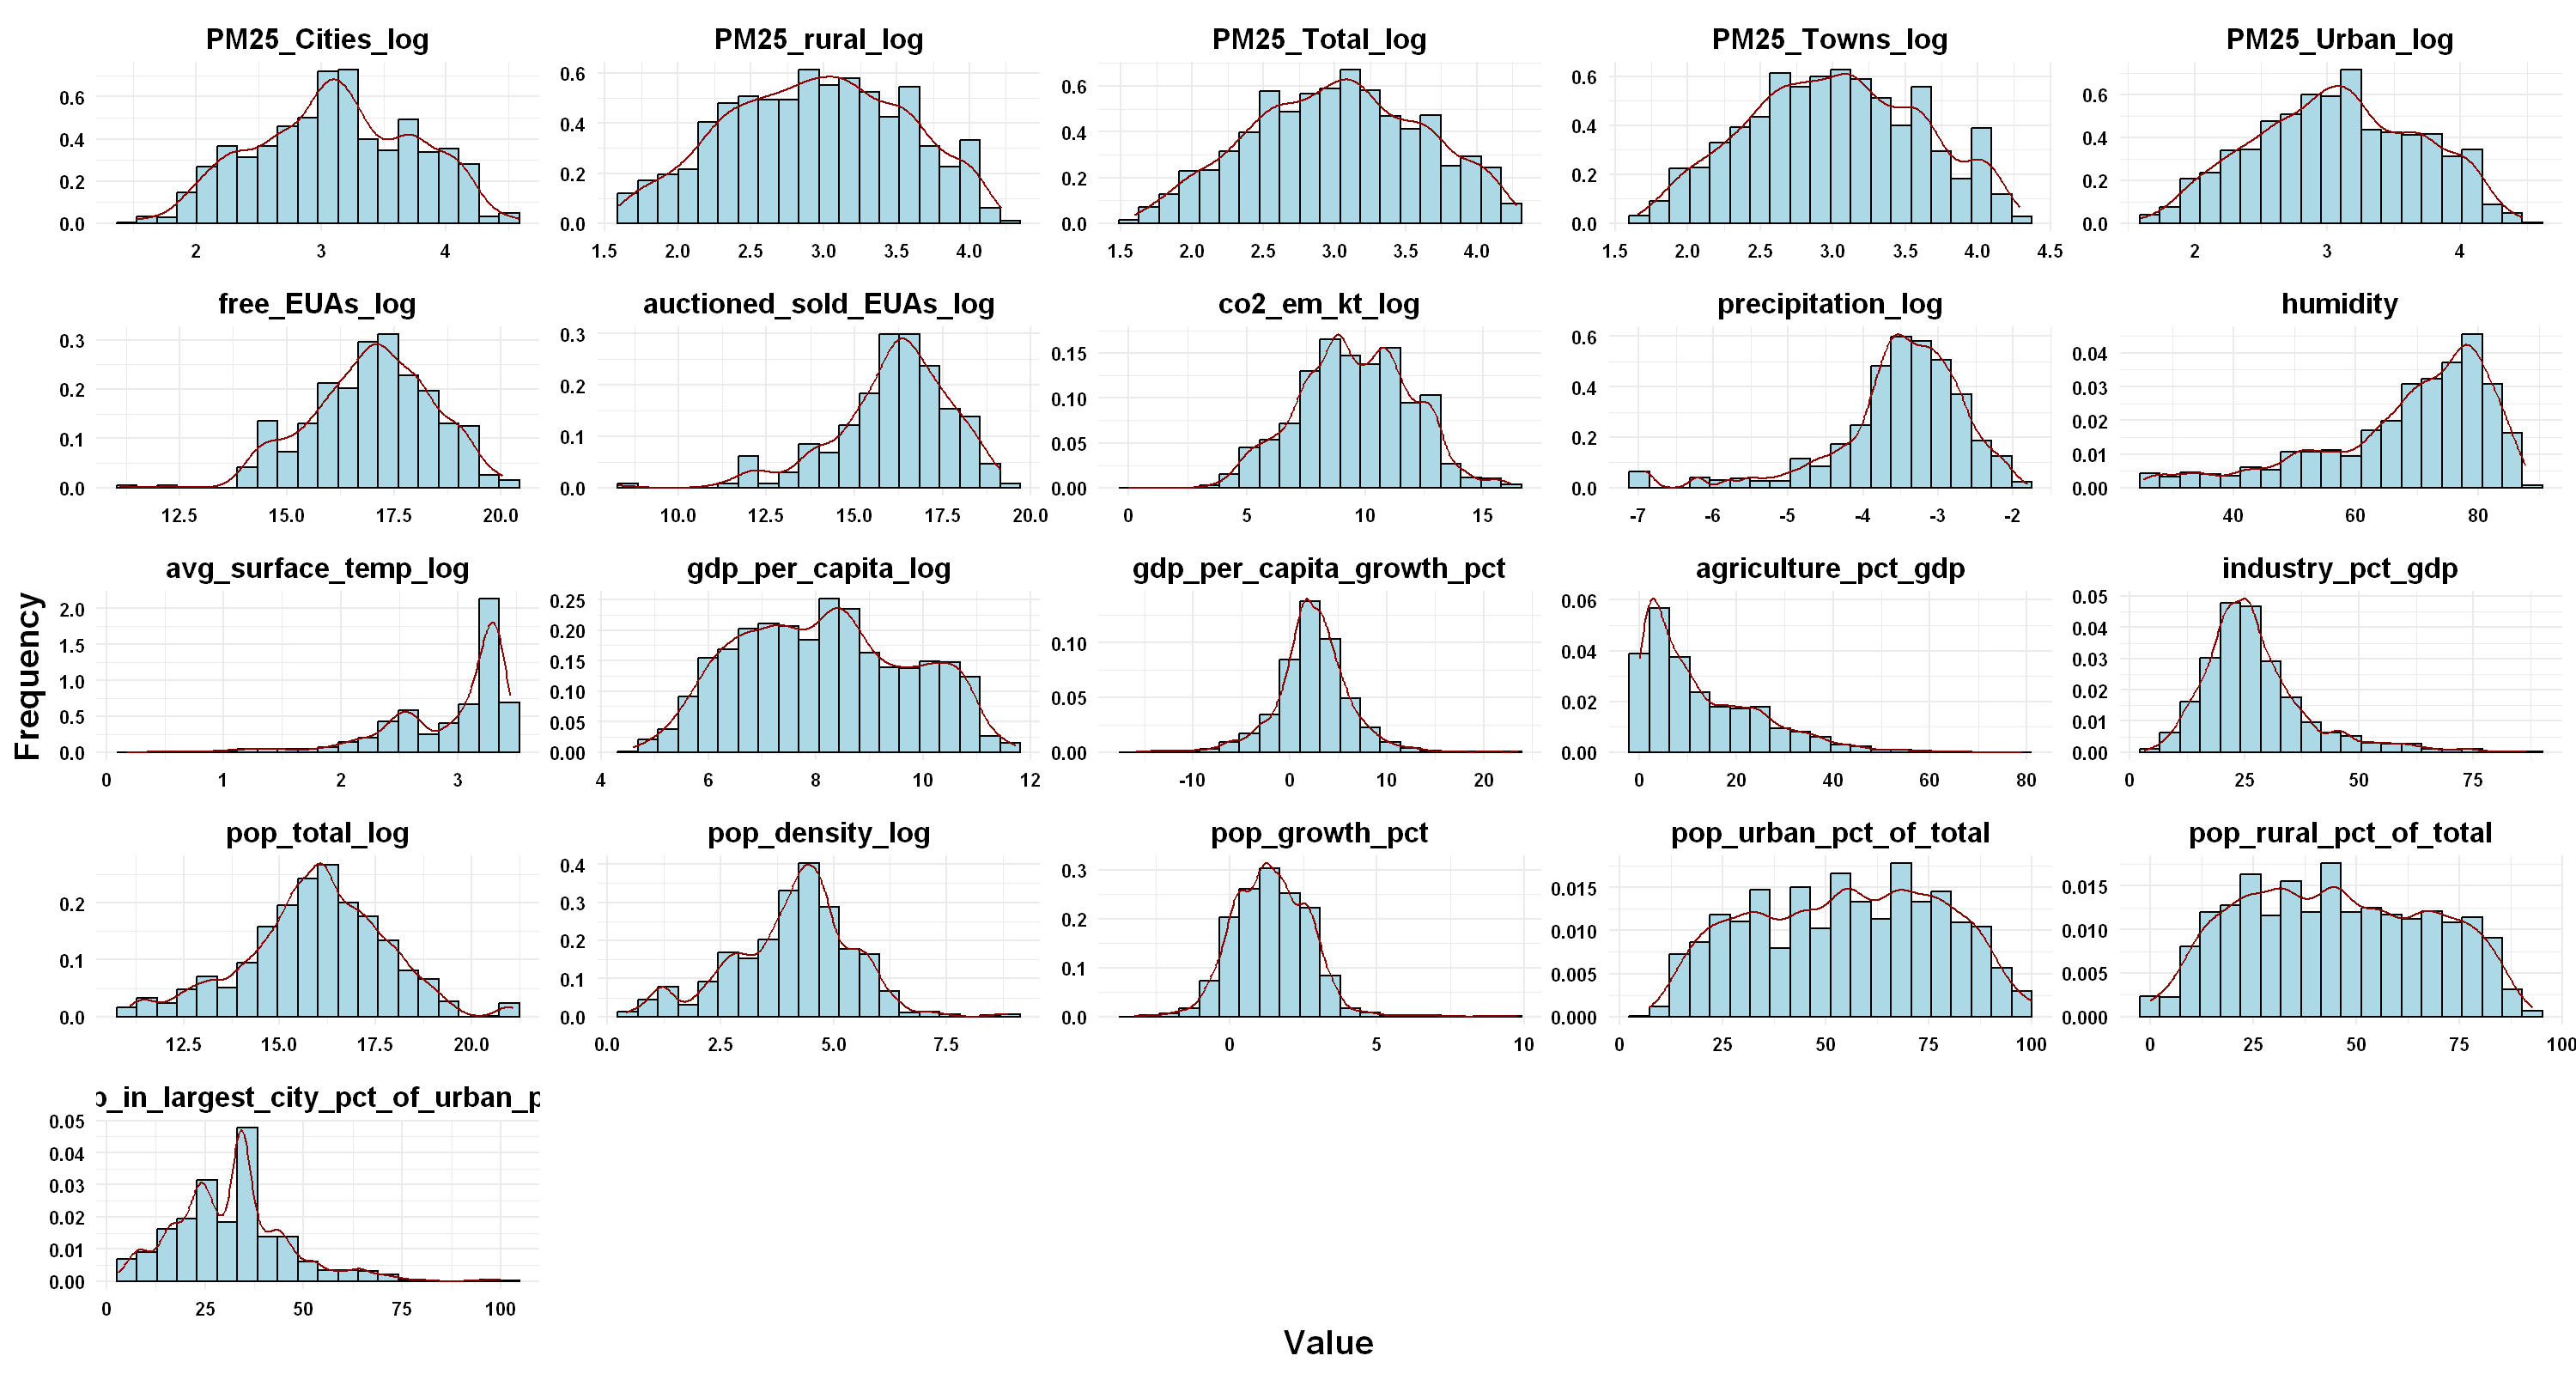

In [19]:
# Define column order of dataset
column_order <- c(
    'PM25_Cities_log', 'PM25_rural_log', 'PM25_Total_log', 'PM25_Towns_log', 'PM25_Urban_log',
    'is_eu_ets', 'free_EUAs_log', 'auctioned_sold_EUAs_log', "co2_em_kt_log",
    'precipitation_log', 'humidity', 'avg_surface_temp_log', 
    'gdp_per_capita_log', 'gdp_per_capita_growth_pct', 'recession_binary', 'agriculture_pct_gdp', 'industry_pct_gdp', 
    'pop_total_log', 'pop_density_log', 'pop_growth_pct', 'pop_urban_pct_of_total', 'pop_rural_pct_of_total', 'pop_in_largest_city_pct_of_urban_pop'
)
# Apply column order
all_indicators_final <- all_indicators_final %>% select(all_of(c("country", "year", column_order)))

# Generate a dataframe for plot only
all_indicators_final_plot <- all_indicators_final %>% mutate(
    free_EUAs_log = ifelse(free_EUAs_log == 0, NA, free_EUAs_log),
    auctioned_sold_EUAs_log = ifelse(auctioned_sold_EUAs_log == 0, NA, auctioned_sold_EUAs_log))
    
# Create a dummy variable for pivot_longer()
all_indicators_final_plot$dummyvar <- "dummyvar"  
# Reshape the dataframe to long format
selected_variables_long <- pivot_longer(all_indicators_final_plot[,setdiff(colnames(all_indicators_final_plot), c("year", "country", "recession_binary", "is_eu_ets"))], -dummyvar)
# Drop created dummy variable
all_indicators_final_plot$dummyvar <- NULL
# Convert 'name' to factor with levels based on original dataset order
# This will help us to generate the plot of columns in defined order
selected_variables_long$name <- factor(selected_variables_long$name, levels = names(all_indicators_final_plot)[!names(all_indicators_final_plot) %in% c("year", "country", "recession_binary", "recession_binary")])
# Create the plot with KDE
plot_vars <- ggplot(selected_variables_long, aes(x = value, y = ..density..)) +
  geom_histogram(bins = 20, fill = "lightblue", color = "black", na.rm = TRUE) +
  geom_density(color = "darkred", adjust = 1, na.rm = TRUE) +  # Adjust the bandwidth
  facet_wrap(~name, scales = "free") +
  labs(x = "Value",
       y = "Frequency")+
  theme_minimal() +
  theme(axis.text.x = element_text(size = 8, color = "black", face = "bold"),
        axis.text.y = element_text(size = 8, color = "black", face = "bold"),
        axis.title = element_text(size = 14, color = "black", face = "bold"),
        strip.text = element_text(size = 12, color = "black", face = "bold")) 

plot(plot_vars)

# Save the plot with adjusted width
ggsave("images/EDA_distribution_plot.jpg", plot_vars, width = 20, height = 12, create.dir = TRUE)

### 2.d. Count of Countries: EU ETS vs Non-EU ETS

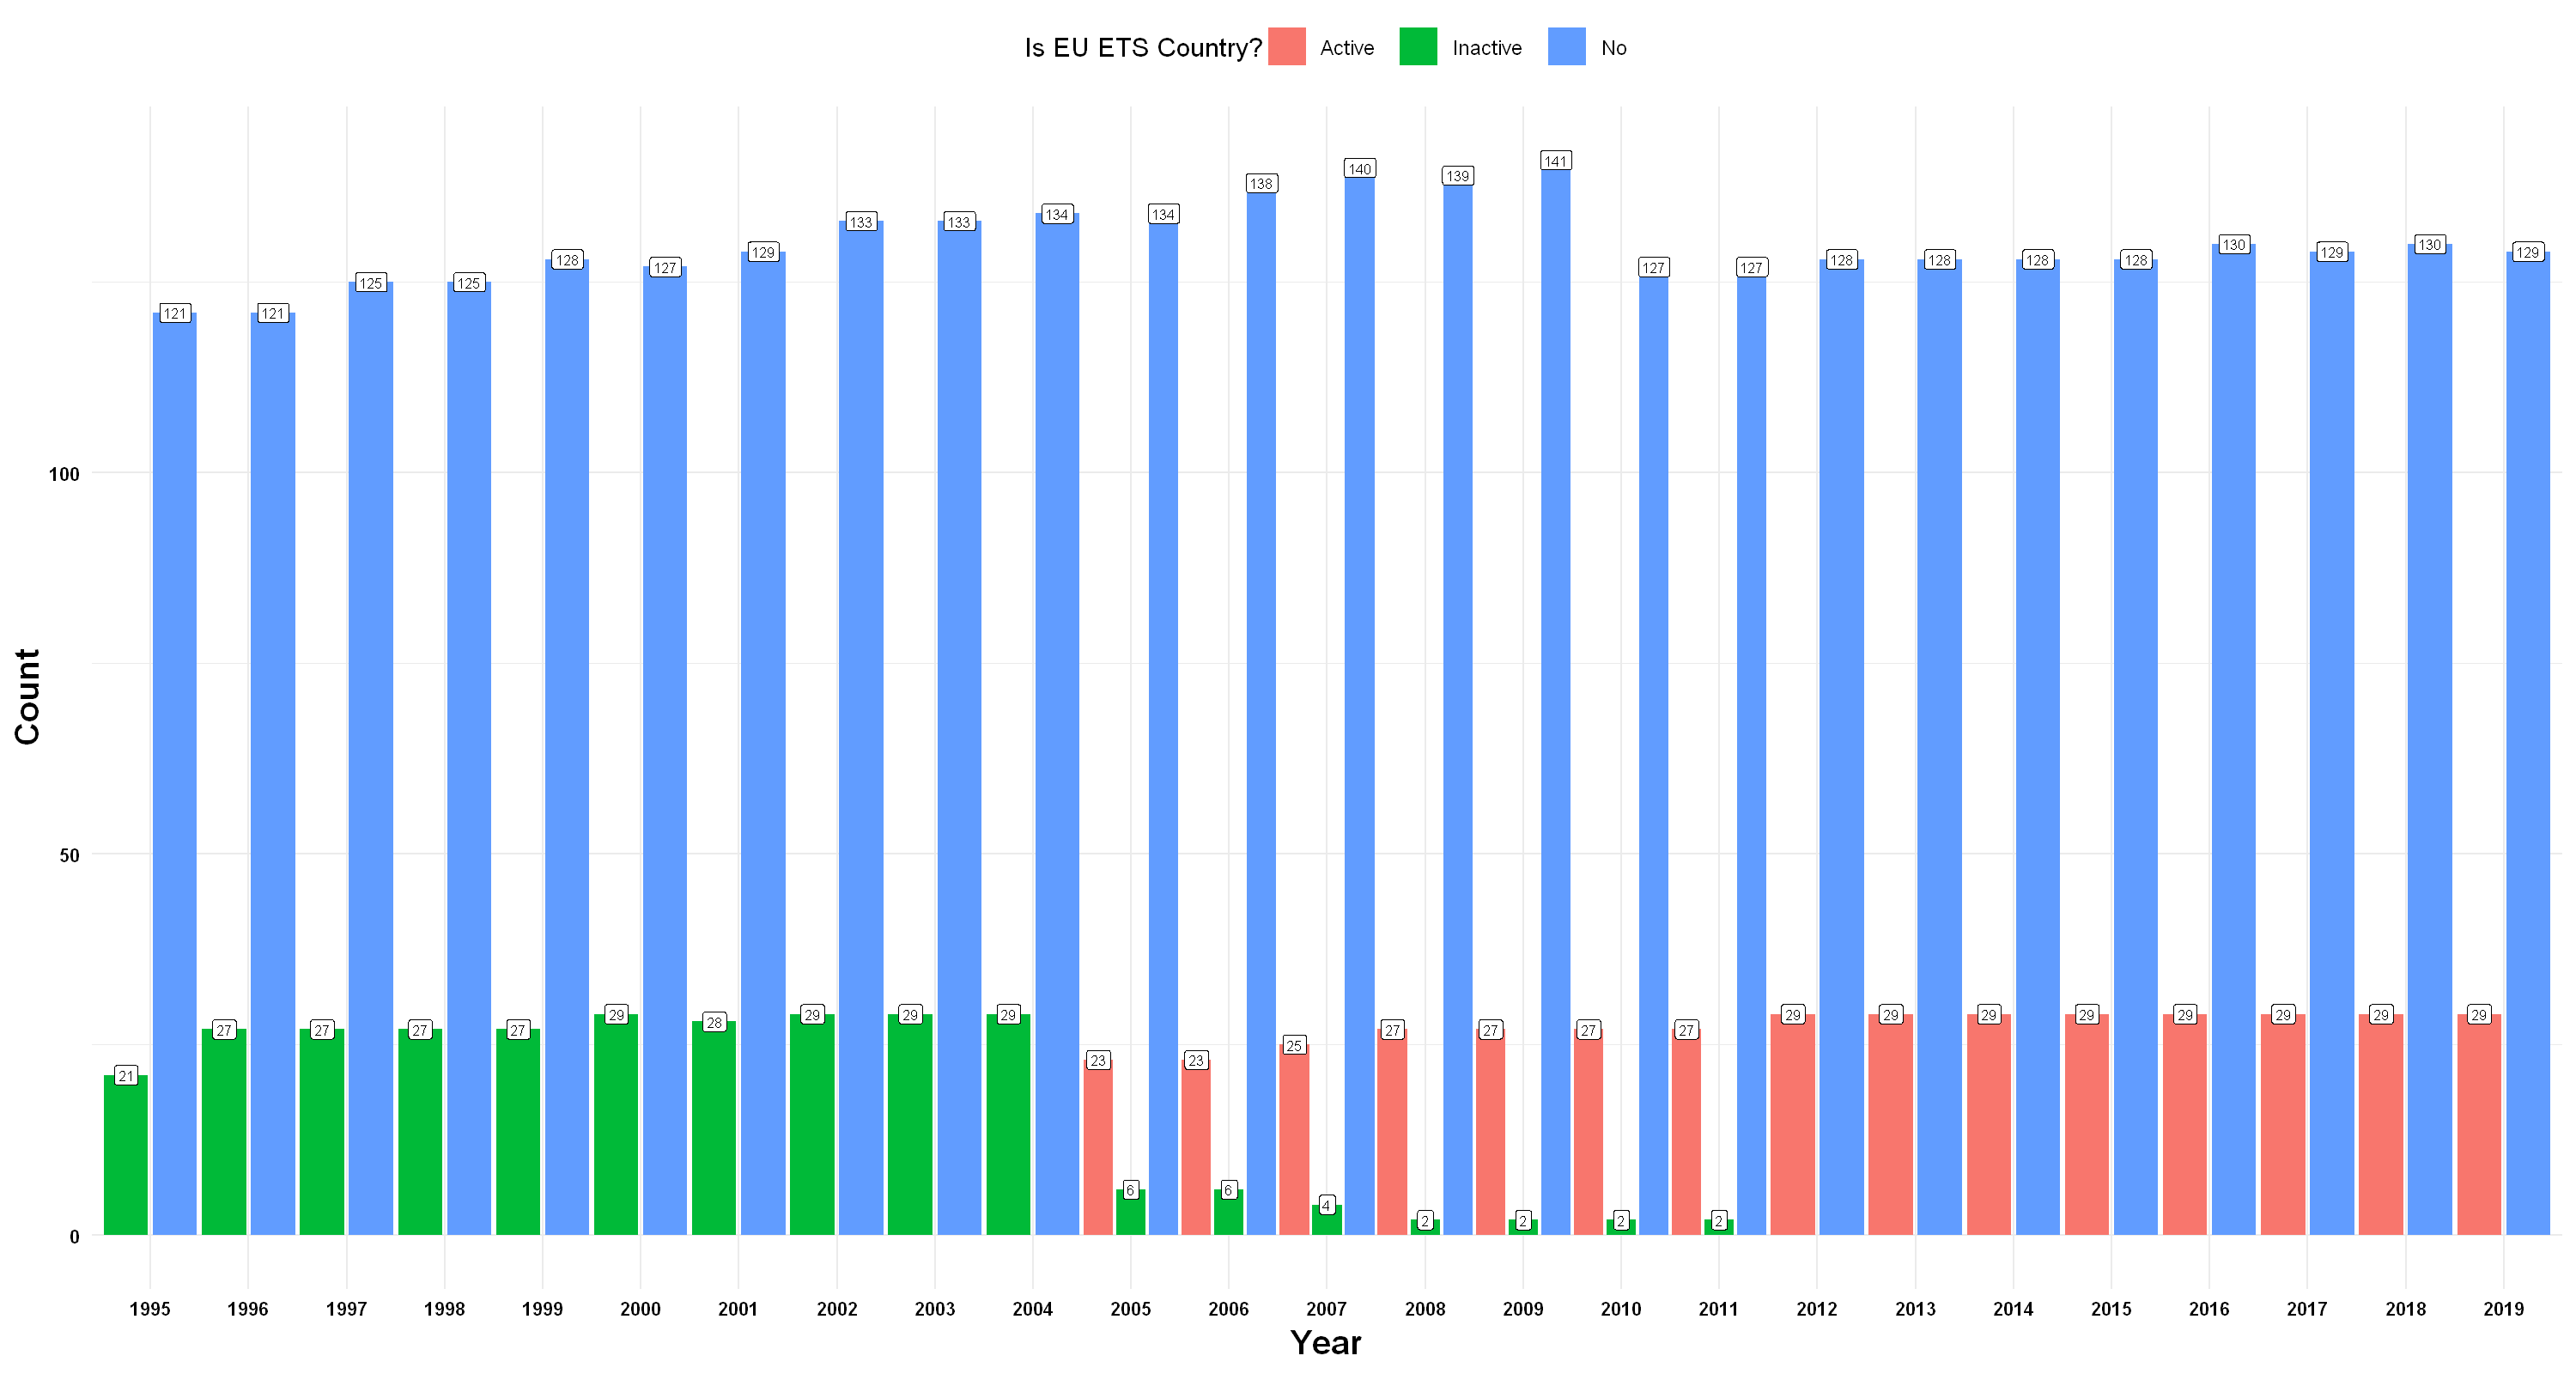

In [20]:
# Count of distinct countries for each year, with EU ETS breakdown
year_country_breakdown <- all_indicators_final %>%
  group_by(year, is_eu_ets) %>%
  summarise(cnt = n(), .groups = 'drop')

# Plot number of countries available in our dataset with EU ETS breakdown
eu_ets_country_breakdown <- ggplot(year_country_breakdown, aes(x=factor(year), y=cnt, group=is_eu_ets)) +
       geom_bar(aes(fill=is_eu_ets),position=position_dodge(width=1), stat="identity") + 
       geom_label(aes(label=cnt),position = position_dodge(width=1), size = 2) +
       labs(x = "Year",
          y = "Count",
          fill = "Is EU ETS Country? ") +
        theme_minimal() + 
        theme(legend.position = "top") +
        theme(axis.text.x = element_text(size = 8, color = "black", face = "bold"),
        axis.text.y = element_text(size = 8, color = "black", face = "bold"),
        axis.title = element_text(size = 14, color = "black", face = "bold"))

eu_ets_country_breakdown

# Save the plot with adjusted width
ggsave("images/EDA_eu_ets_country_breakdown.jpg", eu_ets_country_breakdown, width = 12, height = 5, create.dir = TRUE)

# 3.Matching

Will get back to this point and adjust matching settings after carefully reading the documentation.

In [22]:
top_50_non_ets <- all_indicators_final %>% filter(is_eu_ets == "No") %>% select(c(country,co2_em_kt_log,year)) %>% arrange (year,country) %>%
  pivot_wider(names_from = year, values_from = co2_em_kt_log) %>% drop_na() %>% arrange(-`1995`) %>% 
  head(100) %>% select(country) %>% unique()


Call:
matchit(formula = is_eu_ets ~ +avg_surface_temp_log + pop_total_log + 
    pop_density_log + pop_urban_pct_of_total + pop_rural_pct_of_total, 
    data = all_indicators_final_upto_2005, method = "nearest", 
    distance = "glm", replace = FALSE, ratio = 1)

Summary of Balance for All Data:
                       Means Treated Means Control Std. Mean Diff. Var. Ratio
distance                      0.4783        0.1145          1.6833     1.3172
avg_surface_temp_log          2.3914        3.0398         -1.7706     0.5936
pop_total_log                15.8596       15.9576         -0.0705     0.5402
pop_density_log               4.3990        4.0117          0.3758     0.5644
pop_urban_pct_of_total       71.9439       51.2814          1.7096     0.2874
pop_rural_pct_of_total       28.0561       48.7186         -1.7096     0.2874
                       eCDF Mean eCDF Max
distance                  0.4179   0.7842
avg_surface_temp_log      0.3863   0.7301
pop_total_log             0.05

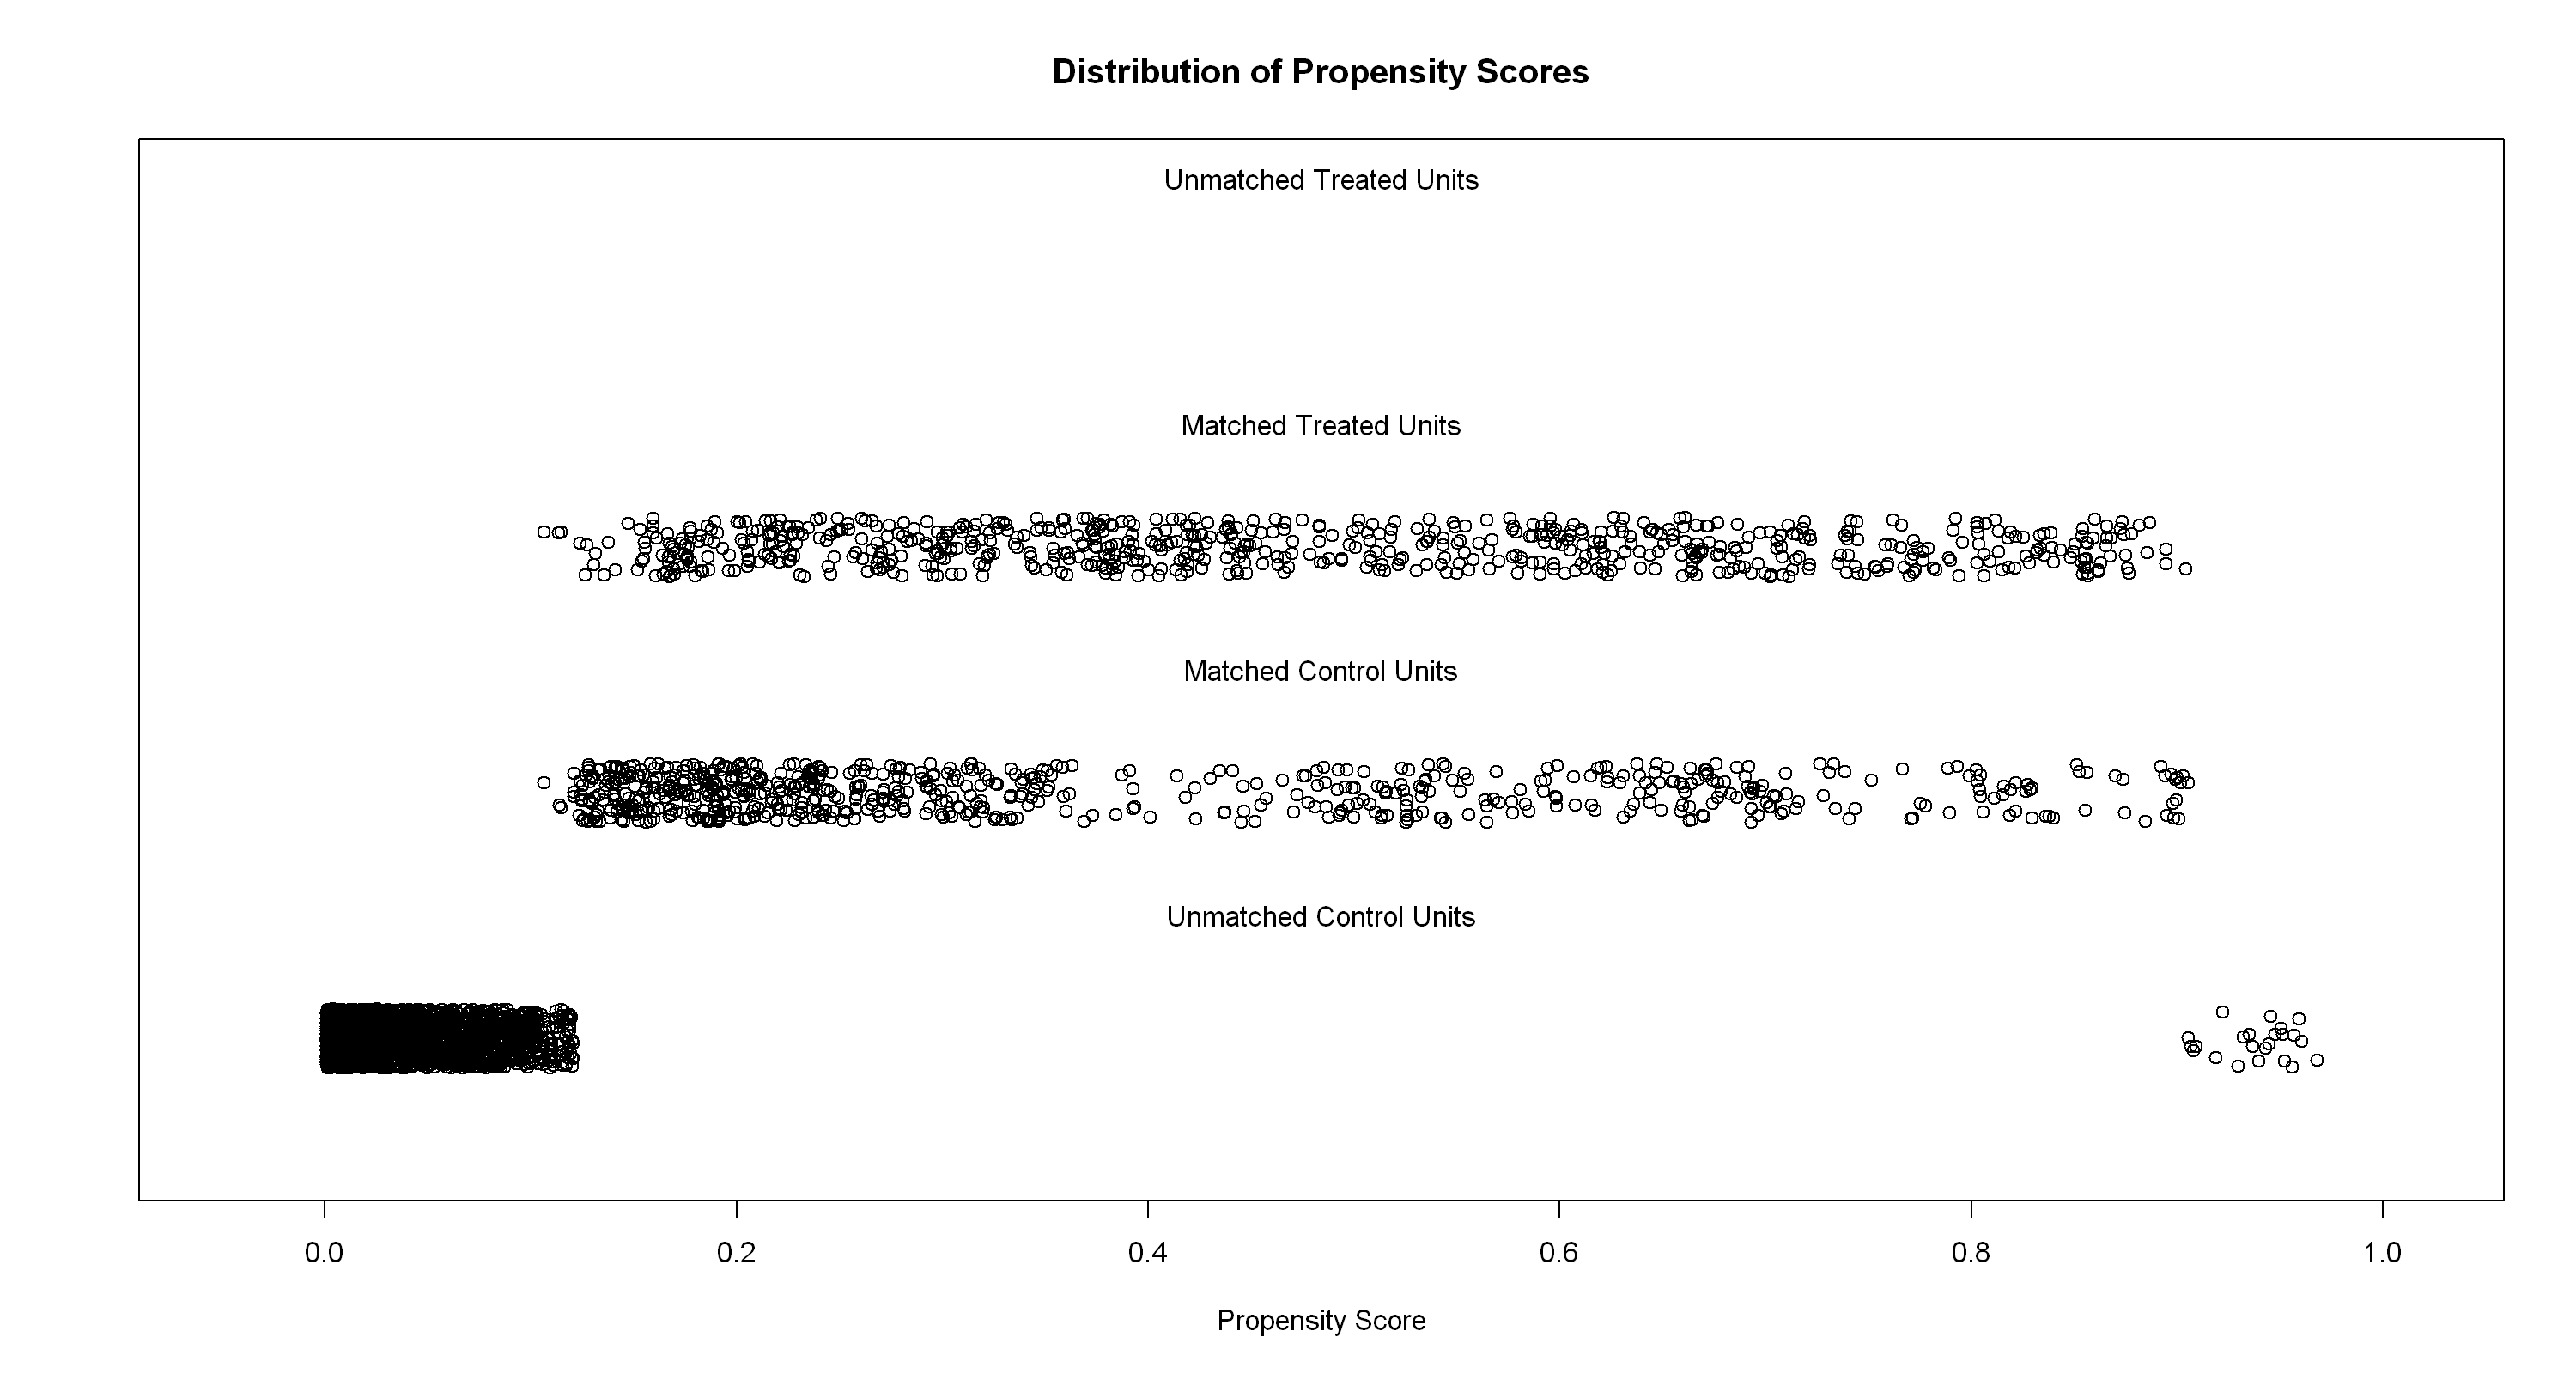

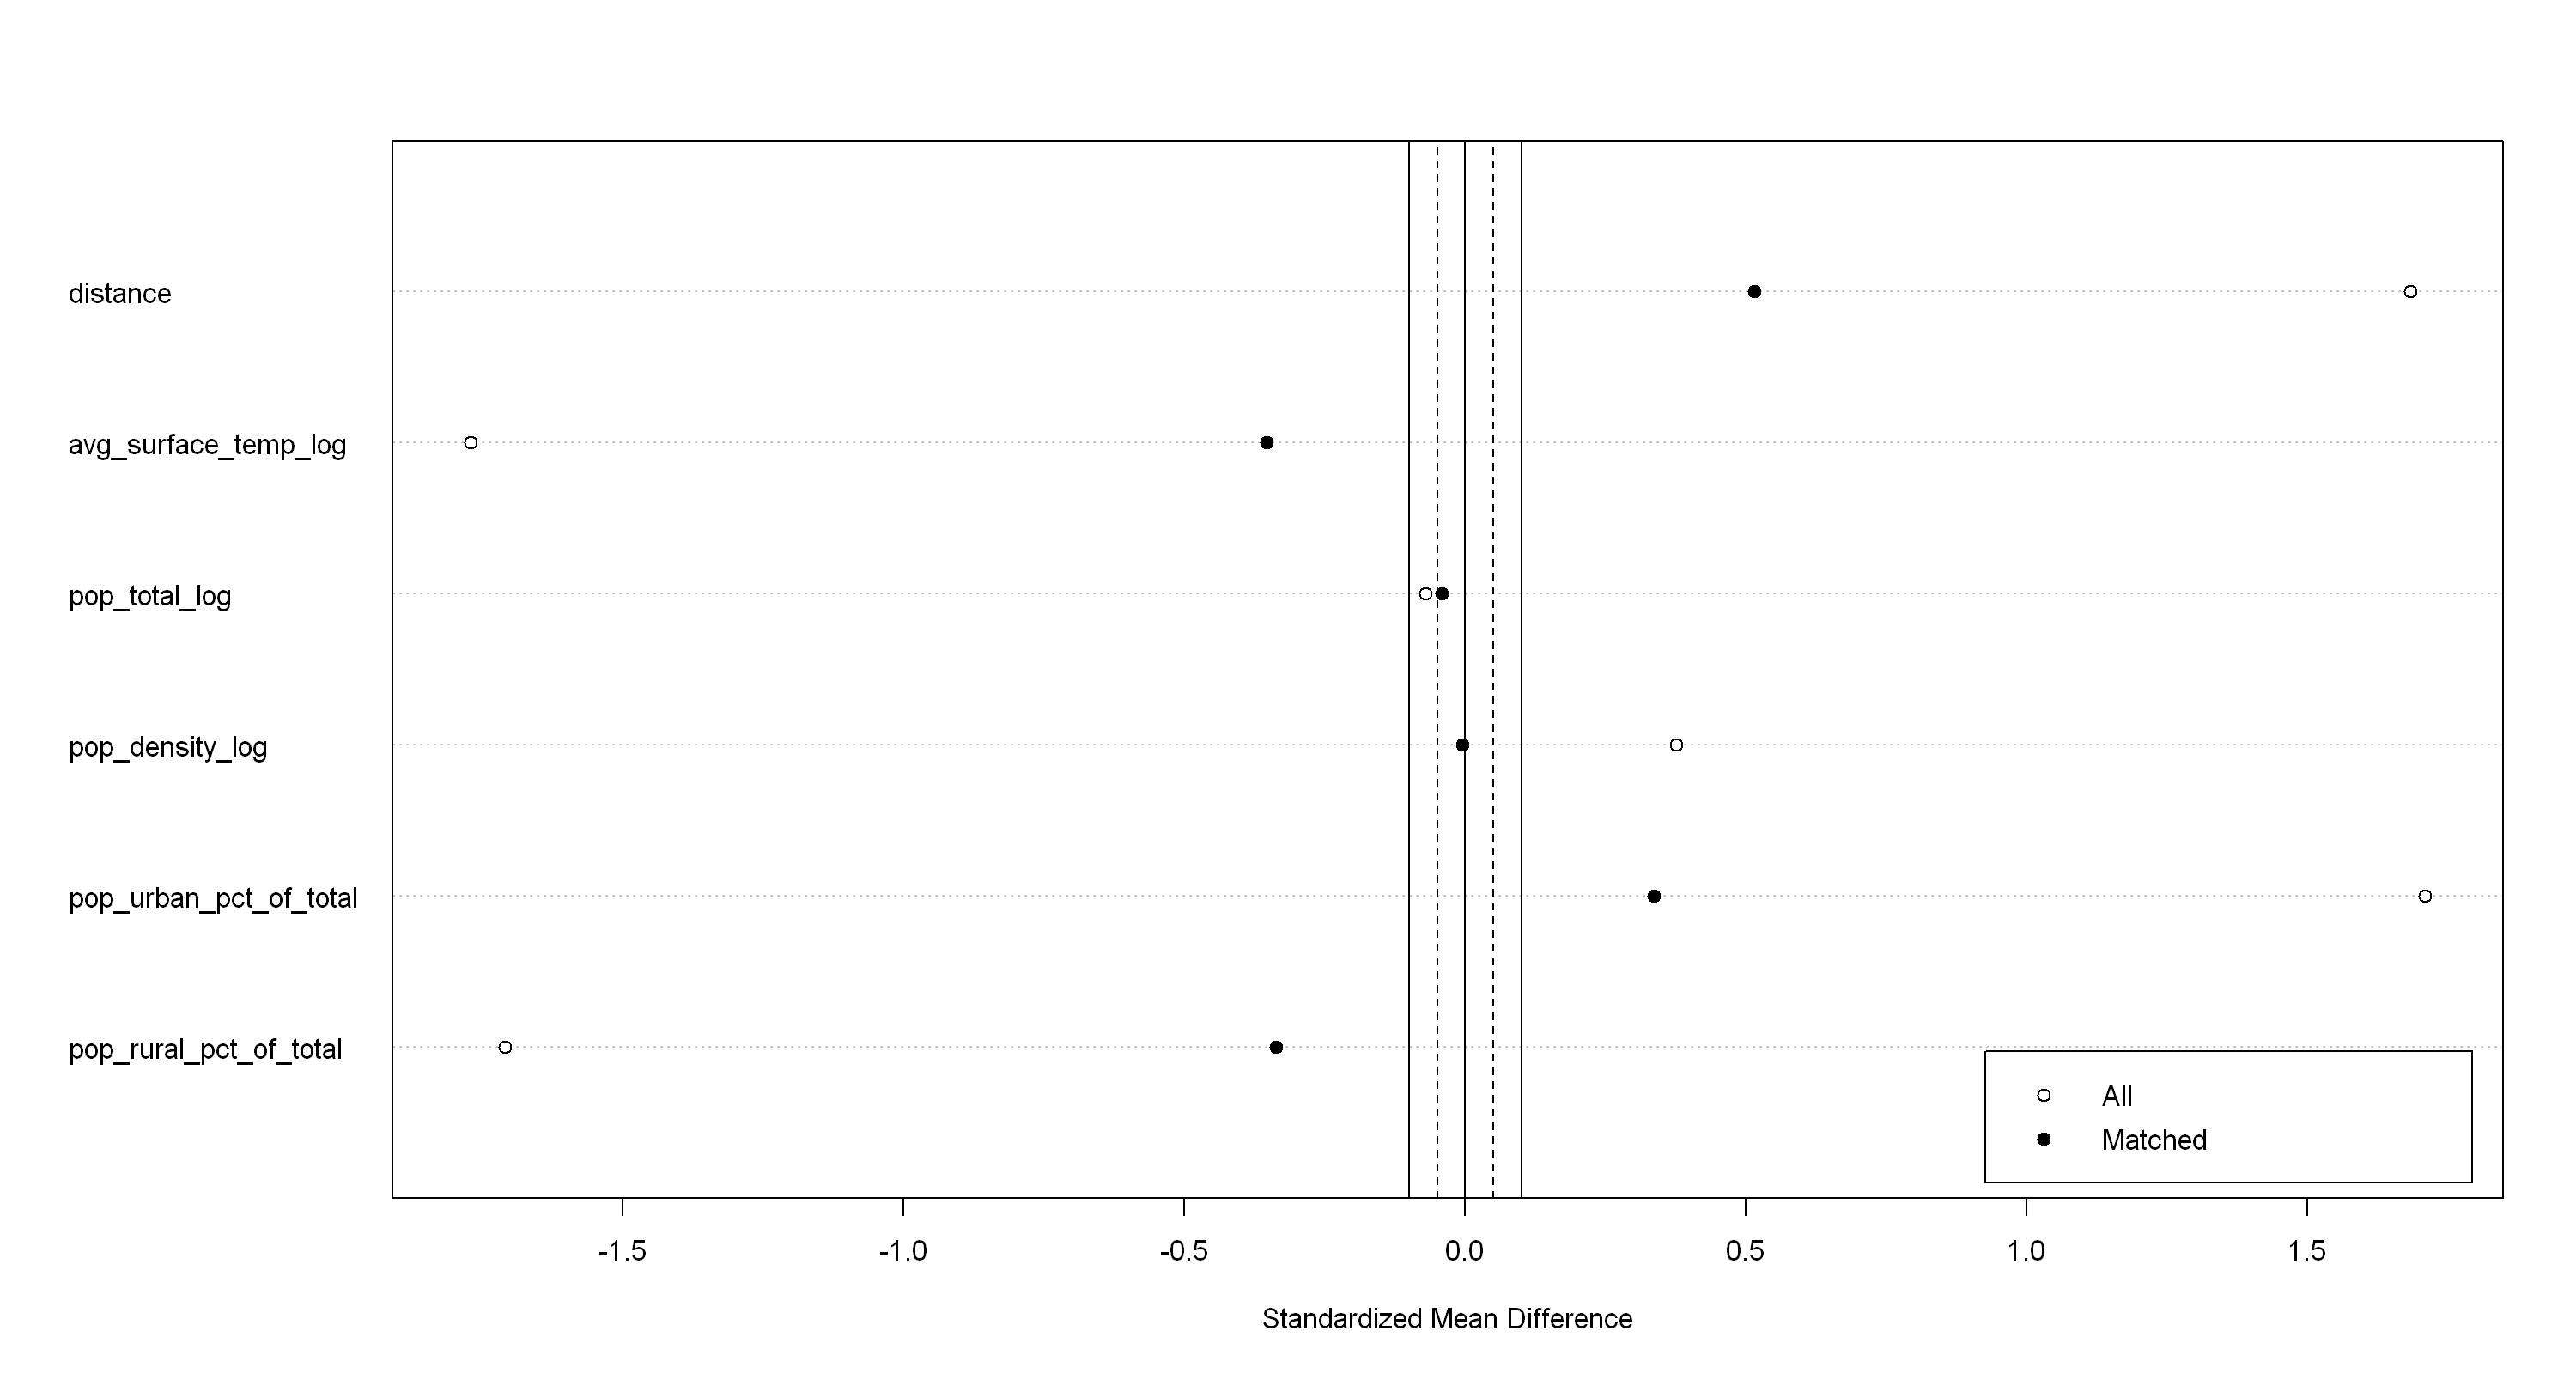

In [30]:
all_indicators_final$is_eu_ets <- ifelse(all_indicators_final$is_eu_ets == "No", 0,1)
# all_indicators_final_upto_2005 <- all_indicators_final_upto_2005 %>% filter(is_eu_ets == 1 | country %in% top_50_non_ets$country)

# Perform propensity score matching using the MatchIt package
# Observed best w avg_surface_temp_log, pop_total_log, pop_density_log, pop_urban_pct_of_total, pop_rural_pct_of_total
  # ,data = all_indicators_final_upto_2005, method = "nearest"
  # ,distance ="glm"
  # ,ratio = 2
  # ,replace = FALSE
match_obj <- matchit(is_eu_ets ~ 
                      # precipitation_log 
                      # + humidity
                      + avg_surface_temp_log 
                      # + gdp_per_capita_log 
                      # + gdp_per_capita_growth_pct
                      # + recession_binary
                      # + agriculture_pct_gdp
                      # + industry_pct_gdp 
                      + pop_total_log 
                      # + pop_in_largest_city_pct_of_urban_pop 
                      # + pop_growth_pct
                      + pop_density_log 
                      + pop_urban_pct_of_total 
                      + pop_rural_pct_of_total

  ,data = all_indicators_final_upto_2005, method = "nearest"
  ,distance ="glm"
  ,ratio = 1
  ,replace = FALSE
  # ,exact = "year"  # Find a match for each treated unit in each year
  )

# Extract the matched subset as a dataframe
matched_subset <- data.frame(match.data(match_obj))
# Print summary statistics of the match object
summary(match_obj)
# Plot the distribution of propensity scores and matches
plot(match_obj, type = "jitter", interactive = FALSE)
# Plot a summary of the match object
plot(summary(match_obj), abs = FALSE)

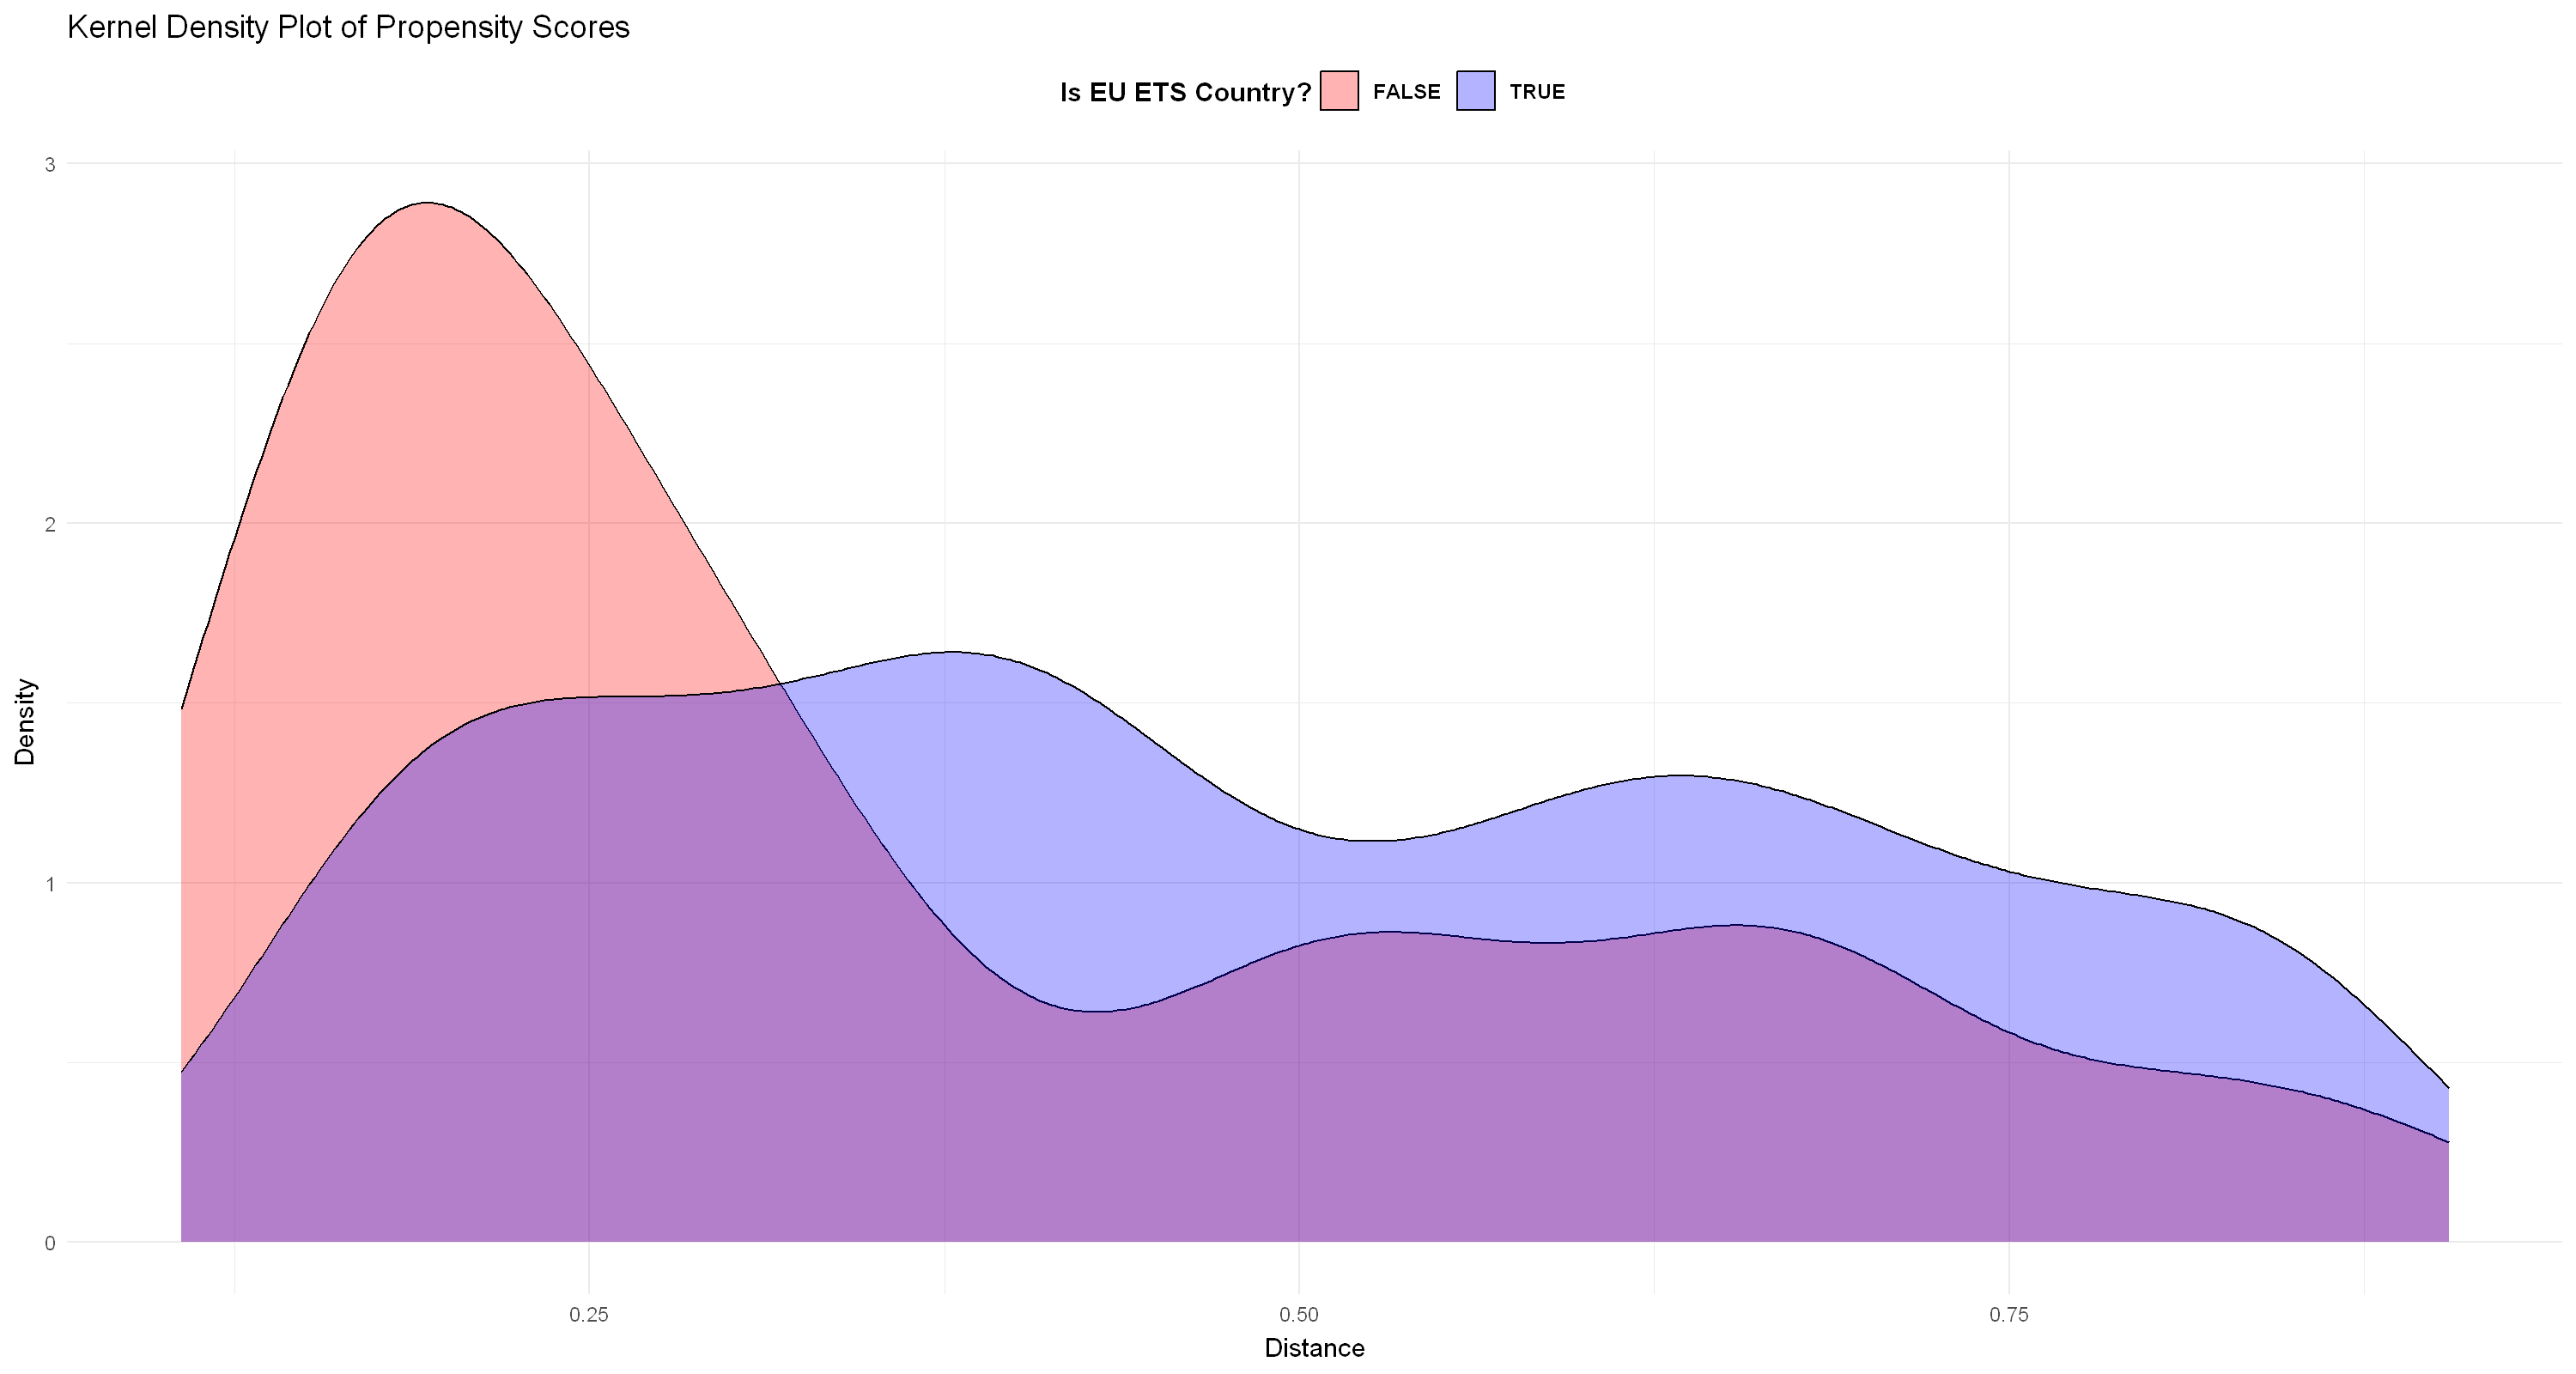

In [31]:
matched_subset$is_eu_ets_binary = ifelse(matched_subset$is_eu_ets == 1, TRUE,FALSE)

# Create the kernel density plot
kernel_density_plot <- ggplot(matched_subset, aes(x = distance, fill = factor(is_eu_ets_binary))) +
  geom_density(alpha = 0.3) +  # Adjust transparency
  labs(title = "Kernel Density Plot of Propensity Scores", x = "Distance", y = "Density", fill = "Is EU ETS Country?") +
  scale_fill_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +  # Define colors
  theme_minimal() +
  theme(
    legend.position = "top",  # Position legend on top
    legend.title = element_text(face = "bold"),  # Bold legend title
    legend.text = element_text(face = "bold")  # Bold legend text
  )

# Display the plot
print(kernel_density_plot)

In [32]:
# Check list of non EU ETS countries in matched sample
unique(matched_subset[matched_subset$is_eu_ets == FALSE,"country"])

[1] "Albania"                "Azerbaijan"             "Belarus"               
 [4] "Chile"                  "Israel"                 "Japan"                 
 [7] "Kazakhstan"             "Kyrgyzstan"             "Lebanon"               
[10] "Mauritius"              "Moldova"                "Mongolia"              
[13] "New Zealand"            "North Macedonia"        "Russian Federation"    
[16] "Singapore"              "Switzerland"            "Turkey"                
[19] "Ukraine"                "Georgia"                "Jordan"                
[22] "Tajikistan"             "United States"          "Bosnia and Herzegovina"
[25] "Canada"                 "Uruguay"                "El Salvador"           
[28] "Bahrain"                "Dominican Republic"     "Montenegro"            
[31] "Serbia"                 "Sao Tome and Principe"  "China"                 
[34] "Kuwait"                 "Costa Rica"             "Qatar"                 
[37] "Armenia"                "Cabo Verde"             "Uzbekistan"            
[40] "United Arab Emirates"   "Haiti"

In [33]:
# Check matches for Germany for different years
matched_subset[(matched_subset$subclass %in% matched_subset[matched_subset$country == "Germany","subclass"]),]%>% arrange (year,is_eu_ets)

country,year,PM25_Cities_log,PM25_rural_log,PM25_Total_log,PM25_Towns_log,PM25_Urban_log,is_eu_ets,free_EUAs_log,auctioned_sold_EUAs_log,⋯,pop_total_log,pop_density_log,pop_growth_pct,pop_urban_pct_of_total,pop_rural_pct_of_total,pop_in_largest_city_pct_of_urban_pop,distance,weights,subclass,is_eu_ets_binary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
Germany,1996,NA,NA,NA,NA,NA,1,0.00000,0.00000,⋯,18.22119,5.4581056,0.28947490,74.133,25.867,5.702614,0.7615678,1,591,TRUE
Kyrgyzstan,1997,NA,NA,NA,NA,NA,0,0.00000,0.00000,⋯,15.36231,3.1980984,1.45850218,35.785,64.215,43.560511,0.5133549,1,283,FALSE
Germany,1997,NA,NA,NA,NA,NA,1,0.00000,0.00000,⋯,18.22265,5.4596833,0.14631328,74.342,25.658,5.644329,0.6608758,1,198,TRUE
Germany,1998,NA,NA,NA,NA,NA,1,0.00000,0.00000,⋯,18.22281,5.4599207,0.01514365,74.551,25.449,5.578663,0.6546109,1,504,TRUE
Japan,1999,NA,NA,NA,NA,NA,0,0.00000,0.00000,⋯,18.65679,5.8505061,0.18258637,78.523,21.477,34.471880,0.5550610,1,316,FALSE
Mongolia,1999,NA,NA,NA,NA,NA,0,0.00000,0.00000,⋯,14.70278,0.4506677,0.96574013,56.623,43.377,53.954779,0.4775537,1,620,FALSE
Germany,1999,NA,NA,NA,NA,NA,1,0.00000,0.00000,⋯,18.22345,5.4606816,0.06463458,74.758,25.242,5.527777,0.6262672,1,587,TRUE
Germany,2000,NA,NA,NA,NA,NA,1,0.00000,0.00000,⋯,18.22481,5.4621219,0.13543160,74.965,25.035,5.491522,0.6101443,1,620,TRUE
Belarus,2001,NA,NA,NA,NA,NA,0,0.00000,0.00000,⋯,16.11092,3.8907324,-0.51296669,70.458,29.542,24.515182,0.4860030,1,151,FALSE


### 3.a. Target variables' trend in matched samples

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


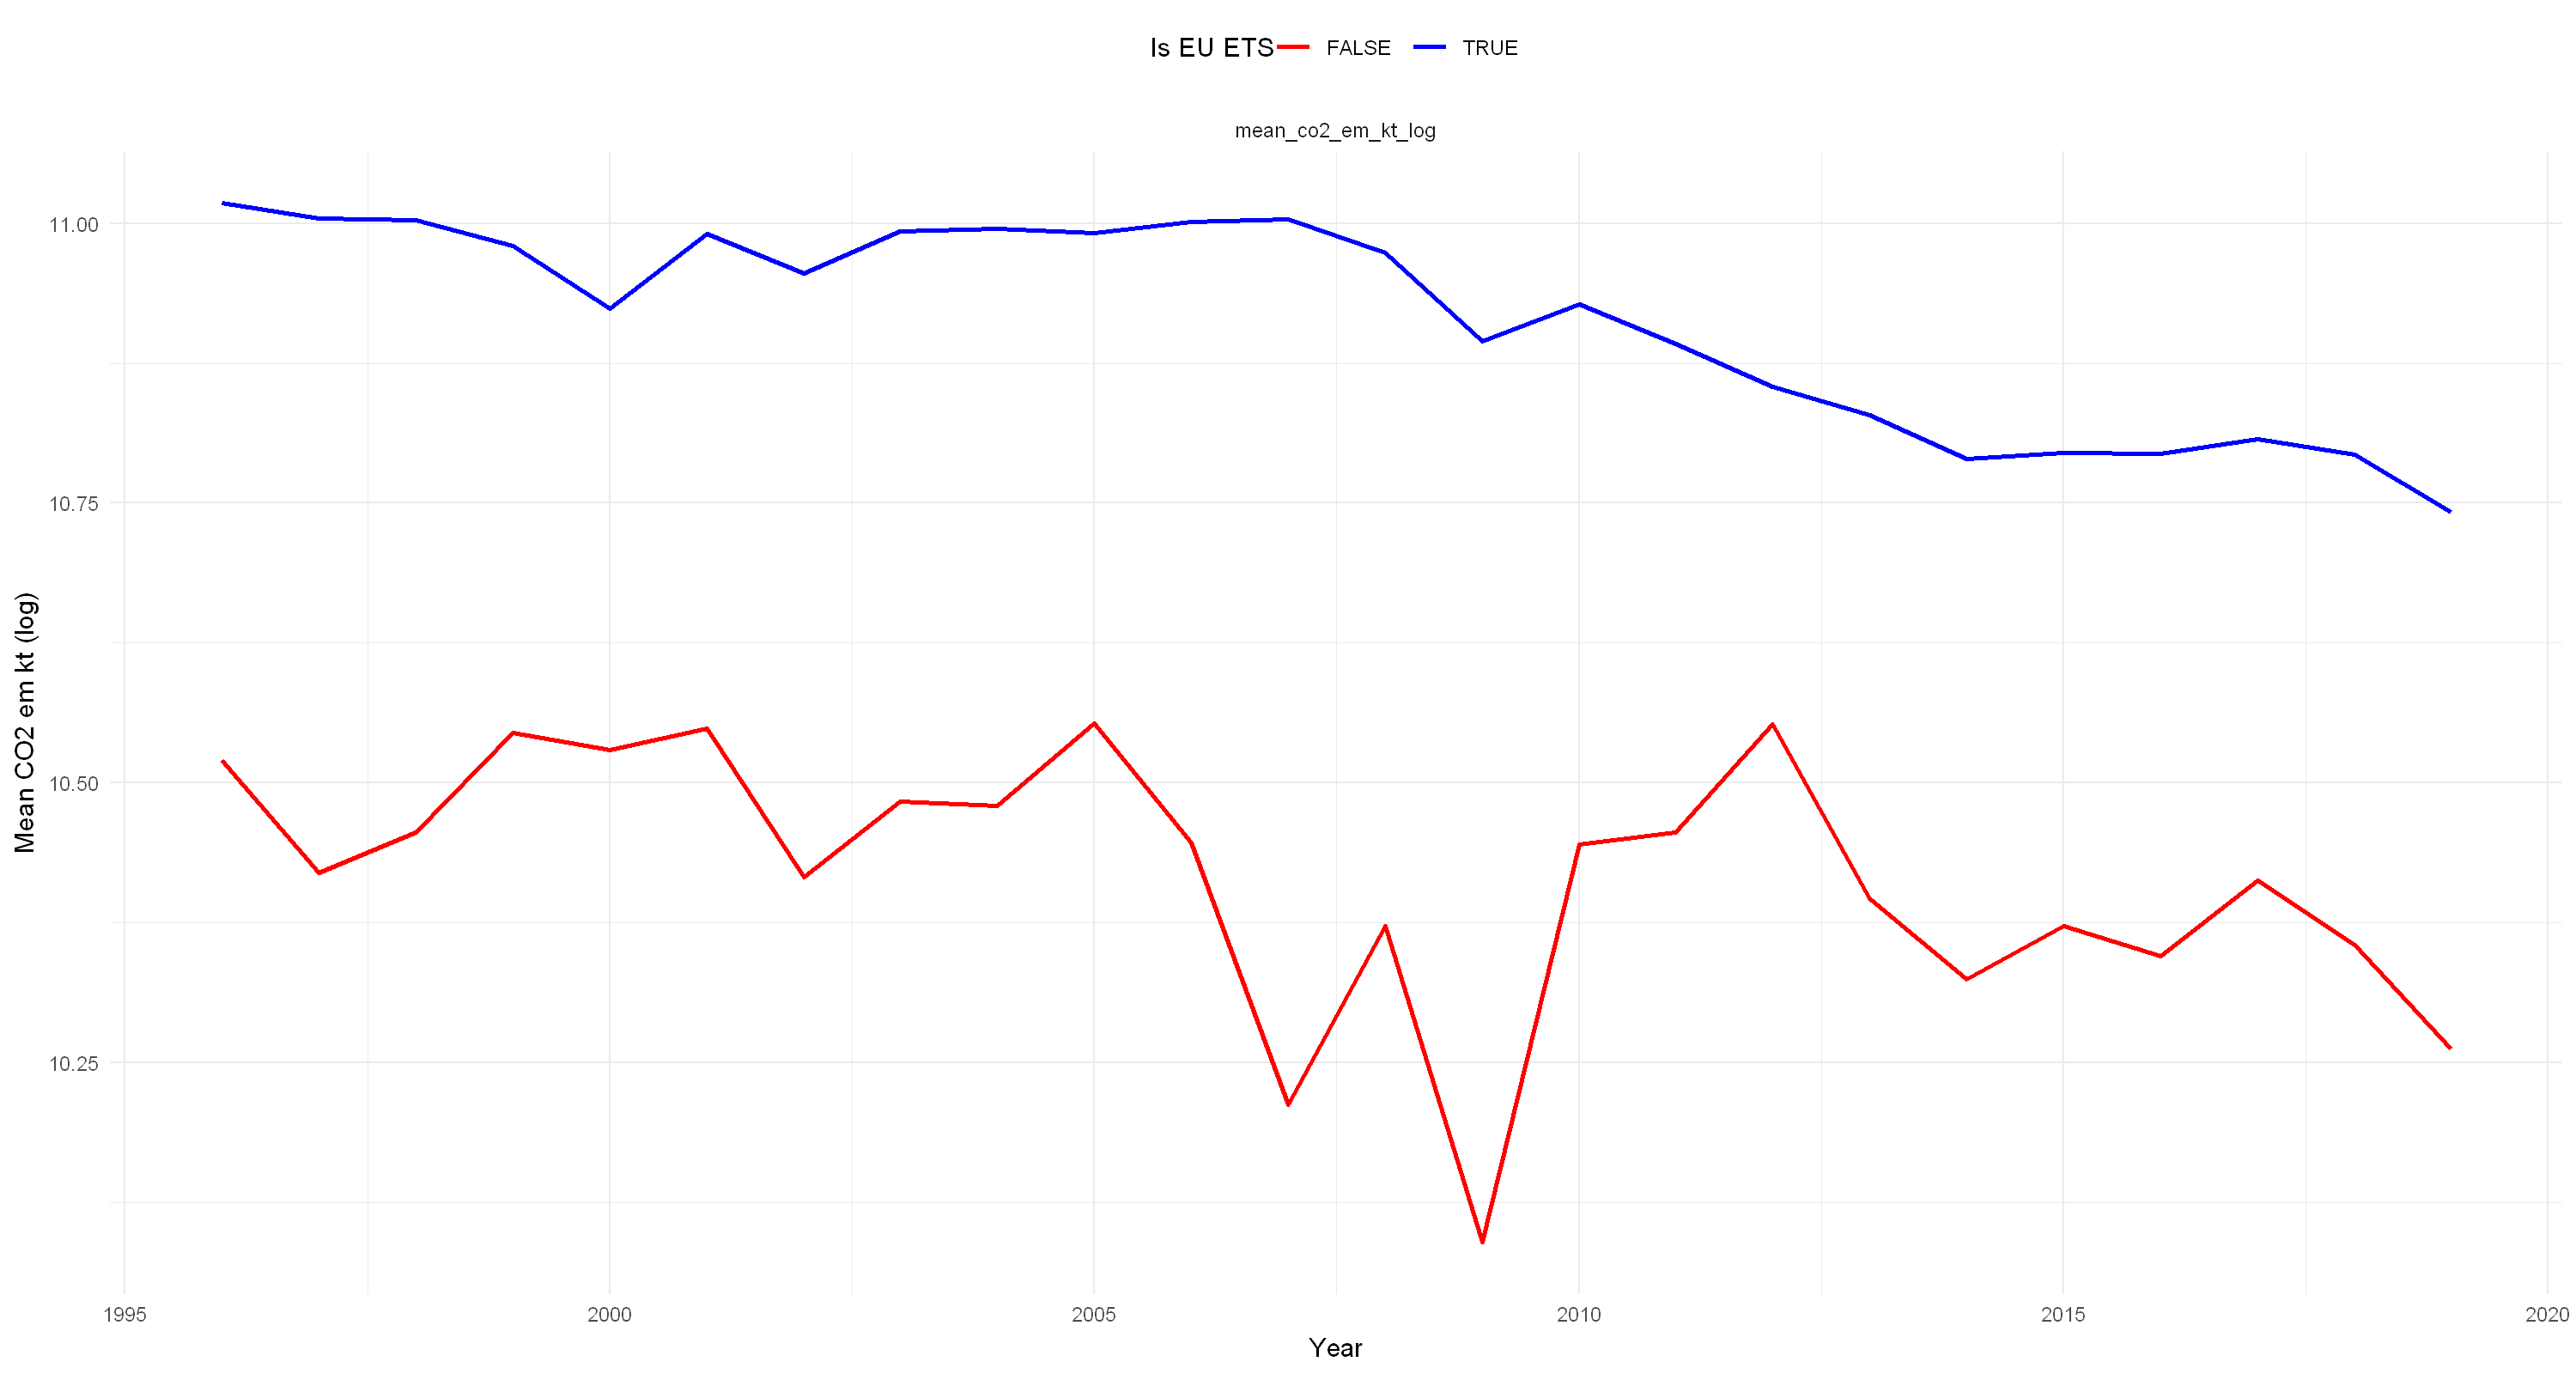

In [34]:
# Create a line plot to visualize the mean PM2.5 values for different types of areas (cities, rural, towns, urban, total) over the years
# The plot shows how the mean PM2.5 values vary over time for EU ETS and non-EU ETS countries
mean_pm25_of_groups <- matched_subset %>%
  # Calculate the mean PM2.5 values for each type of area (cities, rural, towns, urban, total) for each year and is_eu_ets group
  group_by(year, is_eu_ets_binary) %>%
  summarise(mean_co2_em_kt_log = mean(co2_em_kt_log)
    # summarise(mean_PM25_log = mean(PM25_Total_log)
  ) %>%
  # Reshape the data for plotting
  pivot_longer(cols = mean_co2_em_kt_log,
               names_to = "co2_emissions",
               values_to = "mean_co2_em_kt")

# Plotting
ggplot(mean_pm25_of_groups, aes(x = year, y = mean_co2_em_kt, color = as.factor(is_eu_ets_binary))) +
  geom_line(size = 1) +
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue")) +
  facet_wrap(~co2_emissions, scales = "free_y") +
  labs(x = "Year", y = "Mean CO2 em kt (log)", color = "Is EU ETS") +
  theme_minimal() +
  guides(color = guide_legend(title = "Is EU ETS")) +
  scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
  theme(legend.position = "top")


### 3.a. Distributions and differences of matched samples

In [35]:
# Generate a density plot of distributions
# Two densities are produced in each plot: a gray one for control units and a black one for treated
# units. The x-axis corresponds to the value of the covariate and the y-axis corresponds to the density
# or probability of that covariate value in the corresponding group. For binary covariates, bar plots
# are produced, having the same interpretation. Deviations between the black and gray lines represent
# imbalances in the covariate distribution; when the lines coincide (i.e., when only the black line is
# visible), the distributions are identical.
plot(match_obj, type = "density",
  which.xs = ~precipitation_log +
    humidity +
    avg_surface_temp_log +
    gdp_per_capita_log +
    gdp_per_capita_growth_pct +
    recession_binary +
    agriculture_pct_gdp +
    industry_pct_gdp +
    pop_total_log +
    pop_in_largest_city_pct_of_urban_pop +
    pop_growth_pct +
    pop_density_log +
    pop_urban_pct_of_total +
    pop_rural_pct_of_total)

ERROR: Error in eval(predvars, data, env): object 'precipitation_log' not found


In [ ]:
# Generate an eQQ plot of distributions
# The y-axis displays the each value of the covariate for the treated units, 
# and the x-axis displays the the value of the covariate at the corresponding quantile in the control group. 
# When values fall on the 45 degree line, the groups are balanced.
plot(match_obj, type = "qq",
  which.xs = ~precipitation_log +
    humidity +
    avg_surface_temp_log +
    gdp_per_capita_log +
    gdp_per_capita_growth_pct +
    recession_binary +
    agriculture_pct_gdp +
    industry_pct_gdp +
    pop_total_log +
    pop_in_largest_city_pct_of_urban_pop +
    pop_growth_pct +
    pop_density_log +
    pop_urban_pct_of_total +
    pop_rural_pct_of_total)

In [ ]:
# # Create a line plot to visualize the mean of all columns over the years, grouped by EU ETS status
# # The plot shows the trend of mean values of various variables over the years for EU ETS and non-EU ETS countries
# mean_of_all_columns <- matched_subset %>%
#   # Remove unnecessary columns
#   select(-country, -country_code, -distance, -weights, -subclass,
#          -PM25_Cities_log, -PM25_rural_log, -PM25_Towns_log, -PM25_Urban_log, -PM25_Total_log,
#          -free_EUAs_log, -auctioned_sold_EUAs_log, -recession_binary) %>%
#   # Calculate the mean of each variable for each year and is_eu_ets group
#   group_by(year, is_eu_ets) %>%
#   summarise_all(mean, na.rm = TRUE) %>%
#   # Reshape the data for plotting
#   pivot_longer(cols = -c(year, is_eu_ets), names_to = "variable", values_to = "value")

# # Generate the line plot
# ggplot(mean_of_all_columns, aes(x = year, y = value, color = as.factor(is_eu_ets))) +
#   geom_line(size = 0.5) + 
#   scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue")) +
#   labs(x = "Year", y = "Mean Value", color = "Is EU ETS") + 
#   theme_minimal() + 
#   guides(color = guide_legend(title = "Is EU ETS")) +
#   scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) + 
#   facet_wrap(~ variable, scales = "free_y", ncol = 3) + 
#   theme(legend.position = "top")

In [ ]:
# # Create a line plot to visualize the percentage difference of each variable between EU ETS and non-EU ETS countries over the years
# # The plot shows the percentage difference in mean values of various variables between EU ETS and non-EU ETS countries
# # Calculate percentage difference for each variable between EU ETS and non-EU ETS countries
# mean_of_all_columns <- mean_of_all_columns %>%
#   group_by(variable, year) %>%
#   mutate(pct_diff = (value[is_eu_ets == FALSE] - value[is_eu_ets == TRUE]) / value[is_eu_ets == TRUE] * 100)

# # Plotting
# ggplot(mean_of_all_columns, aes(x = year, y = pct_diff, color = variable)) +
#   geom_line(size = 1) +
#   labs(x = "Year", y = "Percentage Difference (%)", color = "Variable") +  # Label axes and legend
#   theme_minimal() +
#   scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
#   facet_wrap(~ variable, scales = "free_y", ncol = 3) +
#   theme(legend.position = "none")